In [0]:
!python -V

Python 3.7.4


In [0]:
# !pip install feature-engine
# !pip install optuna
# # !pip install featexp
# !pip install catboost

In [0]:
# https://yashuseth.blog/2018/07/22/pytorch-neural-network-for-tabular-data-with-categorical-embeddings/
# https://www.kaggle.com/chriszou/titanic-with-pytorch-nn-solution
# https://towardsdatascience.com/tabular-data-analysis-with-deep-neural-nets-d39e10efb6e0

In [0]:
from featexp import get_univariate_plots
from featexp import univariate_plotter
from featexp import get_trend_stats

# Load packages

In [0]:
# from __future__ import division, print_function
import gc
import os
import pathlib
import re
import pandas as pd
import numpy as np
from numpy.linalg import svd
from numba import jit
import itertools
from copy import deepcopy
from contextlib import contextmanager
from collections import namedtuple
from sklearn_pandas import DataFrameMapper
from sklearn.pipeline import Pipeline as pipe
from feature_engine import categorical_encoders as ce
from feature_engine import discretisers as dsc
import concurrent.futures

from sklearn.feature_selection import RFE
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn import metrics
from sklearn.model_selection import (cross_val_score, train_test_split, ShuffleSplit, StratifiedKFold, KFold,
                                    learning_curve, TimeSeriesSplit, RepeatedKFold)

from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier,
                             VotingClassifier, ExtraTreesClassifier)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from scipy import stats 
from scipy.special import boxcox1p

from scipy.stats import rankdata
from sklearn.preprocessing import (MinMaxScaler, Binarizer, StandardScaler, OneHotEncoder,
                                  Normalizer, RobustScaler, OrdinalEncoder, LabelEncoder)
import lightgbm as lgb
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier, plot_importance, plot_metric
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

pd.set_option('display.max_columns', 130)

import warnings
warnings.filterwarnings("ignore")

Populating the interactive namespace from numpy and matplotlib


In [0]:
colab_path = '/content/drive/My Drive/'
pickle.dump(mapper_fit, open('fitted_mapper.pkl', 'wb'))
# mapper_fit = pickle.load(open('fitted_mapper.pkl', 'rb'))

In [0]:
colab_path = '/content/drive/My Drive/'
# with open( os.path.join(colab_path,'list_dict.json'), 'w') as fp:
#     json.dump(list_dicts, fp)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
colab_train_path = pathlib.Path('/content/drive/My Drive/ott_train')
Xtrain = pd.read_pickle(colab_train_path/'train.pkl')
Xtest = pd.read_pickle(colab_train_path/'test.pkl')
targets = pd.read_pickle(colab_train_path/'targets.pkl')

In [0]:
Y = targets['goal24']

# Functions

In [0]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                c_prec = df[col].apply(lambda x: np.finfo(x).precision).max()
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max and c_prec == np.finfo(np.float16).precision:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max and c_prec == np.finfo(np.float32).precision:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

@jit
def fast_auc(y_true, y_prob):
    """
    fast roc_auc computation: https://www.kaggle.com/c/microsoft-malware-prediction/discussion/76013
    """
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += (1 - y_i)
        auc += y_i * nfalse
    auc /= (nfalse * (n - nfalse))
    return auc

def eval_auc(y_true, y_pred):
    """
    Fast auc eval function for lgb.
    """
    return 'auc', fast_auc(y_true, y_pred), True


def train_model_classification(X, X_test, y, params, folds, model_type='lgb', eval_metric='auc', 
                               columns=None, plot_feature_importance=False, model=None,
                               verbose=10000, early_stopping_rounds=200, n_estimators=50000):
    """
    A function to train a variety of regression models.
    Returns dictionary with oof predictions, test predictions, scores and, if necessary, feature importances.
    
    :params: X - training data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: X_test - test data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: y - target
    :params: folds - folds to split data
    :params: model_type - type of model to use
    :params: eval_metric - metric to use
    :params: columns - columns to use. If None - use all columns
    :params: plot_feature_importance - whether to plot feature importance of LGB
    :params: model - sklearn model, works only for "sklearn" model type
    
    """
    columns = X.columns if columns == None else columns
    X_test = X_test[columns]
    
    # to set up scoring parameters
    metrics_dict = {'auc': {'lgb_metric_name': eval_auc,
                        'catboost_metric_name': 'AUC',
                        'sklearn_scoring_function': metrics.roc_auc_score},
                    }
    
    result_dict = {}
    
    # out-of-fold predictions on train data
    oof = np.zeros((len(X), len(set(y.values))))
    
    # averaged predictions on train data
    prediction = np.zeros((len(X_test), oof.shape[1]))
    
    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()
    
    # split and train on folds
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        if model_type == 'lgb':
            model = lgb.LGBMClassifier(**params, n_estimators=n_estimators, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=metrics_dict[eval_metric]['lgb_metric_name'],
                    verbose=verbose, early_stopping_rounds=early_stopping_rounds)
            
            y_pred_valid = model.predict_proba(X_valid)
            y_pred = model.predict_proba(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=n_estimators, evals=watchlist, 
                              early_stopping_rounds=early_stopping_rounds, verbose_eval=verbose, params=params)
            
            y_pred_valid = model.predict_proba(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict_proba(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict_proba(X_valid).reshape(-1,)
            score = metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid)
            print(f'Fold {fold_n}. {eval_metric}: {score:.4f}.')
            print('')
            
            y_pred = model.predict_proba(X_test)
        
        if model_type == 'cat':
            model = CatBoostClassifier(iterations=n_estimators, eval_metric=metrics_dict[eval_metric]['catboost_metric_name'], **params)
                                      #loss_function='CrossEntropy') #  metrics_dict[eval_metric]['catboost_metric_name'])
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=cats_indices, plot=True, use_best_model=True, verbose=False) # cats_indices

            y_pred_valid = model.predict_proba(X_valid)
            y_pred = model.predict_proba(X_test)
        
        oof[valid_index] = y_pred_valid
        scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid[:, 1]))

        prediction += y_pred    
        
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= folds.n_splits
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= folds.n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
        
    return result_dict

def make_harmonic_features(df, column):
    for col in column:
        period = df[col].nunique()
        value = df[col].copy()
        value *= 2 * np.pi / period
        df[col + '_cos'] = np.cos(value, dtype='float32')
        df[col + '_sin'] = np.sin(value, dtype='float32')
    return (df)

def make_conj(data, feat1, feat2):
    """
    inplace
    """
    new_name = feat1 + '_' + feat2
    data[new_name] = data[feat1].astype(str)+ '_' + data[feat2].astype(str)
    data[new_name] = LabelEncoder().fit_transform(data[new_name])
    

# по значениям другого категориального признака
def code_factor(data, cat_feature, cat_feature2):
    ct = pd.crosstab(data[cat_feature], data[cat_feature2])
    u, _, _ = svd(ct.values)
    coder = dict(zip(ct.index, u[:, 0])) # если кодирование первой компонентой
    return (data[cat_feature].map(coder))

def make_real_feature(df, name, group_col='userid'):
    """
    вычисление разных статистик
    """
    tmp = df.groupby(group_col)[name].agg({np.mean, max, min, np.median, sum, np.std}).fillna(-1)
    tmp.columns = [name + '_' + str(x) for x in tmp.columns]
    tmp = tmp.reset_index()
    return (tmp[tmp.columns[tmp.nunique()>1]])


# Load dataset
def load_ottrip(train=True):

  cols_to_rename = {'field0': 'ndays_from_last',
                 'field2': 'month_buy',
                 'field3': 'month_depart',
                 'field4': 'order_of_buy',
                 'field9': 'ticket_child_1y',
                 'field11': 'hour_of_buy',
                 'field15': 'total_tickets',
                 'field16': 'days_before_depart',
                 'field18': 'dow_buy',
                 'field20': 'dow_depart',
                 'field21': 'year',
                 'field23': 'hour_depart',
                 'field24': 'ticket_adult',
                 'field28': 'ticket_child_4y',
                 'field29': 'quarter'}

  for k, v in cols_to_rename.items():
    cols_to_rename[k] = v.upper() 

  train_file = 'onetwotrip_challenge_train.csv'
  test_file = 'onetwotrip_challenge_test.csv'
  f = train_file if train else test_file
  colab_path = '/content/drive/My Drive/'
  data = pd.read_csv(os.path.join(colab_path , f))
  data.rename(columns=cols_to_rename, inplace=True)

  data['YEAR']=(data.YEAR == 1).astype(uint16)
  data['field7']=(data.field7 == 1).astype(uint16)
  data['userid'] = LabelEncoder().fit_transform(data.userid)
  data['USR_CNT'] = data.userid.map(data.groupby('userid').size())
  indicator_cols=list(filter(lambda x: 'indicat' in x, data.columns))
  data['INDICATOR_CNT'] = data[indicator_cols].apply(lambda x: np.sum(x.astype(uint8))/5, axis=1).astype(np.float16)
  data = reduce_mem_usage(data)
  print(data.shape)

  return data

def load_ottrip_without_userid_encoding(train=True):

  cols_to_rename = {'field0': 'ndays_from_last',
                 'field2': 'month_buy',
                 'field3': 'month_depart',
                 'field4': 'order_of_buy',
                 'field9': 'ticket_child_1y',
                 'field11': 'hour_of_buy',
                 'field15': 'total_tickets',
                 'field16': 'days_before_depart',
                 'field18': 'dow_buy',
                 'field20': 'dow_depart',
                 'field21': 'year',
                 'field23': 'hour_depart',
                 'field24': 'ticket_adult',
                 'field28': 'ticket_child_4y',
                 'field29': 'quarter'}

  for k, v in cols_to_rename.items():
    cols_to_rename[k] = v.upper() 

  train_file = 'onetwotrip_challenge_train.csv'
  test_file = 'onetwotrip_challenge_test.csv'
  f = train_file if train else test_file
  colab_path = '/content/drive/My Drive/'
  data = pd.read_csv(os.path.join(colab_path , f))
  data.rename(columns=cols_to_rename, inplace=True)

  data['YEAR']=(data.YEAR == 1).astype(uint16)
  data['field7']=(data.field7 == 1).astype(uint16)
  indicator_cols=list(filter(lambda x: 'indicat' in x, data.columns))
  data['INDICATOR_CNT'] = data[indicator_cols].apply(lambda x: np.sum(x.astype(uint8))/5, axis=1).astype(np.float16)
  data = reduce_mem_usage(data)
  print(data.shape)

  return data


def drop_corr_cols(df, upper_tresh=0.9):
  corr_matrix = df.corr().abs()
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
  to_drop = [column for column in upper.columns if any(upper[column] > upper_tresh)]

  return to_drop

colab_subm_path = '/content/drive/My Drive/ottrip_subm/'
colab_path = '/content/drive/My Drive/'

SEED = 17
TEST_SIZE = 0.3
SPLITS = 10

# ==== cv strategy ====
shuffle_split = ShuffleSplit(n_splits=SPLITS, test_size=TEST_SIZE, random_state=SEED)
skf = StratifiedKFold(n_splits=SPLITS, shuffle=True, random_state=SEED)

# Load Data


In [0]:
df = load_ottrip()

df.head()

Mem. usage decreased to 15.71 Mb (75.4% reduction)
(196056, 45)


,orderid,userid,NDAYS_FROM_LAST,field1,MONTH_BUY,MONTH_DEPART,ORDER_OF_BUY,field5,field6,field7,field8,TICKET_CHILD_1Y,field10,HOUR_OF_BUY,field12,field13,field14,TOTAL_TICKETS,DAYS_BEFORE_DEPART,field17,DOW_BUY,field19,DOW_DEPART,YEAR,field22,HOUR_DEPART,TICKET_ADULT,field25,field26,field27,TICKET_CHILD_4Y,QUARTER,indicator_goal21,indicator_goal22,indicator_goal23,indicator_goal24,indicator_goal25,goal21,goal22,goal23,goal24,goal25,goal1,USR_CNT,INDICATOR_CNT
0,0,7458,0,-0.626508,11,12,1,1,0,1,1,0,0,9,5,20,-0.661308,1,4,1,4,1,1,1,1,15,1,1,2,1,0,4,1,1,0,1,1,0,1,0,0,0,0,1,0.799805
1,1,33232,144,-0.393794,5,7,2,0,0,0,1,0,0,21,125,3,-0.101043,1,57,1,5,1,6,0,121,15,1,41,3,1,0,2,1,1,0,1,0,0,0,0,0,0,0,2,0.600098
2,2,83136,134,-0.548937,2,3,2,0,0,1,1,0,1,7,4,3,-0.661308,1,4,1,2,3,6,0,17,14,1,1,11,7,0,1,1,1,0,1,1,0,0,0,0,0,0,2,0.799805
3,3,1583,0,-0.238651,10,11,1,1,3,0,1,0,0,19,12,3,-0.521242,2,22,1,3,3,4,1,46,12,2,18,1,1,0,4,1,1,0,1,1,0,0,0,0,0,0,3,0.799805
4,4,93298,0,-0.704079,8,11,1,1,0,1,1,0,1,16,4,3,-0.801375,1,100,1,6,1,1,1,17,22,1,1,1,1,0,3,1,1,0,0,1,0,0,0,0,0,0,1,0.600098


In [0]:
indicator_cols=list(filter(lambda x: 'indicat' in x, df.columns))
goals_cols=['goal21', 'goal22', 'goal23', 'goal24', 'goal25']
cat_cols=['MONTH_BUY', 'MONTH_DEPART', 'field5', 'field7', 'field8',
 'field10', 'DOW_BUY', 'DOW_DEPART', 'YEAR', 'HOUR_DEPART', 'field27', 'QUARTER']+indicator_cols+goals_cols

to_harmonic_cols =['MONTH_BUY', 'MONTH_DEPART', 'HOUR_OF_BUY', 'HOUR_DEPART', 'DOW_BUY', 
                  'DOW_DEPART', 'QUARTER', 'field27']

to_ohe_cols = ['MONTH_BUY', 'MONTH_DEPART', 'HOUR_OF_BUY', 'HOUR_DEPART', 'DOW_BUY', 'DOW_DEPART', 'QUARTER', 'field27']

make_real_feats=['ORDER_OF_BUY', 'TICKET_CHILD_1Y', 'DAYS_BEFORE_DEPART',
       'DIFF_HOUR_DEPART&HOUR_OF_BUY', 'DIFF_MONTH_DEPART&MONTH_BUY',
       'field1', 'field12', 'field13', 'field14', 'field17', 'field19',
       'field22', 'field25', 'field26', 'field6', 'INDICATOR_CNT', 'NDAYS_FROM_LAST',
       'NDAYS_LAST_NEXT', 'TICKET_ADULT', 'TICKET_CHILD_4Y','TOTAL_TICKETS', 'USR_CNT', 'WEEKS_BEFORE_DEPART']

In [0]:
df_test = load_ottrip(train=False)

df_test.head()

Mem. usage decreased to 33.85 Mb (73.5% reduction)
(455011, 39)


,orderid,userid,NDAYS_FROM_LAST,field1,MONTH_BUY,MONTH_DEPART,ORDER_OF_BUY,field5,field6,field7,field8,TICKET_CHILD_1Y,field10,HOUR_OF_BUY,field12,field13,field14,TOTAL_TICKETS,DAYS_BEFORE_DEPART,field17,DOW_BUY,field19,DOW_DEPART,YEAR,field22,HOUR_DEPART,TICKET_ADULT,field25,field26,field27,TICKET_CHILD_4Y,QUARTER,indicator_goal21,indicator_goal22,indicator_goal23,indicator_goal24,indicator_goal25,USR_CNT,INDICATOR_CNT
0,0,60209,0,-0.548937,10,10,1,1,0,1,1,0,1,23,2,23,-0.521242,1,1,1,2,2,3,1,20,15,1,1,1,1,0,4,1,1,0,0,1,2,0.600098
1,1,47274,82,-0.626508,3,4,3,0,0,1,1,0,1,14,4,3,-0.661308,1,19,1,6,1,4,0,17,14,1,1,1,1,0,1,1,1,0,1,1,3,0.799805
2,2,33843,0,-0.548937,6,8,1,1,0,0,1,0,1,13,4,3,-0.521242,1,39,1,1,1,5,1,101,8,1,35,1,1,0,2,1,0,0,1,1,2,0.600098
3,3,245314,6,0.304348,7,7,2,0,10,1,0,0,0,20,19,3,0.879422,1,18,1,4,1,1,1,16,16,1,1,3,1,0,3,1,1,0,1,1,2,0.799805
4,4,168484,115,-0.471365,3,3,2,0,0,1,1,0,1,20,4,5,-0.661308,2,8,1,2,1,3,0,1,13,2,1,1,1,0,1,1,1,0,1,1,2,0.799805


# SUBM 2

## subm2 base 0.715428

In [0]:
# Load dataset
def load_ottrip(train=True):

  cols_to_rename = {'field0': 'ndays_from_last',
                 'field2': 'month_buy',
                 'field3': 'month_depart',
                 'field4': 'order_of_buy',
                 'field9': 'ticket_child_1y',
                 'field11': 'hour_of_buy',
                 'field15': 'total_tickets',
                 'field16': 'days_before_depart',
                 'field18': 'dow_buy',
                 'field20': 'dow_depart',
                 'field21': 'year',
                 'field23': 'hour_depart',
                 'field24': 'ticket_adult',
                 'field28': 'ticket_child_4y',
                 'field29': 'quarter'}

  for k, v in cols_to_rename.items():
    cols_to_rename[k] = v.upper() 

  train_file = 'onetwotrip_challenge_train.csv'
  test_file = 'onetwotrip_challenge_test.csv'
  f = train_file if train else test_file
  colab_path = '/content/drive/My Drive/'
  data = pd.read_csv(os.path.join(colab_path , f))
  data.rename(columns=cols_to_rename, inplace=True)

  data['YEAR']=(data.YEAR == 1).astype(uint16)
  data['field7']=(data.field7 == 1).astype(uint16)
  data = reduce_mem_usage(data)
  print(data.shape)

  return data

In [0]:
df = load_ottrip()
df_test = load_ottrip(train=False)
df_test['USR_CNT'] = df_test.userid.map(df_test.groupby('userid').size())
df_test['INDICATOR_CNT'] = df_test[indicator_cols].apply(lambda x: np.sum(x.astype(uint8))/5, axis=1).astype(np.float16
                                                                                                             
to_scale = ['NDAYS_FROM_LAST', 'ORDER_OF_BUY', 'field6', 'TICKET_CHILD_1Y',
           'field12', 'field13', 'TOTAL_TICKETS', 'DAYS_BEFORE_DEPART', 'field17', 'field19',
           'field22', 'TICKET_ADULT', 'field25', 'field26', 'TICKET_CHILD_4Y', 'USR_CNT']

df_copy = df.copy()
df_test_copy = df_test.copy()
scaler = RobustScaler().fit(df_copy[to_scale])
df_copy[to_scale] = scaler.transform(df_copy[to_scale])
df_test_copy[to_scale] = scaler.transform(df_test_copy[to_scale])                                                                                                             

In [0]:
df_train=df_copy.drop(['orderid', 'userid', 'goal1'], axis=1)
df_test=df_test_copy.drop(['orderid', 'userid'], axis=1)

n_fold = 10
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)
list_goals = []

for cycle, goal in enumerate(['goal25', 'goal23', 'goal24', 'goal22', 'goal21']):

  print(f"\nstart training process... cycle =====> {cycle+1}")
 
  X = df_train.drop( np.setdiff1d(goals_cols, list_goals).tolist(), axis=1)
  Y = df_train[goal]

  used_goals = list(filter(lambda x: 'goal' in x and 'indicator' not in x, X.columns))

  print(f"use goal columns =====> {used_goals} to predict ====> {goal}\n")

  res_dict=train_model_classification(X=X, X_test=df_test, y=Y, params=params, folds=folds, model_type='lgb', eval_metric='auc', 
                               columns=None, plot_feature_importance=False, model=None,
                               verbose=10000, early_stopping_rounds=200, n_estimators=50000)

  list_goals.append(goal)

  df_test[goal] = res_dict['prediction'][:, 1]

  test_goals = list(filter(lambda x: 'goal' in x and 'indicator' not in x, df_test.columns))
  print(f"\ntest set contains: {test_goals}")

  if cycle == 4:
    probas = pd.concat([df_test['goal21'], df_test['goal22'], df_test['goal23'], 
                        df_test['goal24'], df_test['goal25']], axis=1)
    
    colab_path = '/content/drive/My Drive/'
    
    probas.to_csv( os.path.join(colab_path,'sub2.csv') )
    print("process completed successfully!")

## 2_1  0.71597

In [0]:
print(X.columns.tolist(), end=', ')

['NDAYS_FROM_LAST', 'field1', 'MONTH_BUY', 'MONTH_DEPART', 'ORDER_OF_BUY', 'field5', 'field6', 'field7', 'field8', 'TICKET_CHILD_1Y', 'field10', 'HOUR_OF_BUY', 'field12', 'field13', 'field14', 'TOTAL_TICKETS', 'DAYS_BEFORE_DEPART', 'field17', 'DOW_BUY', 'field19', 'DOW_DEPART', 'YEAR', 'field22', 'HOUR_DEPART', 'TICKET_ADULT', 'field25', 'field26', 'field27', 'TICKET_CHILD_4Y', 'indicator_goal21', 'indicator_goal22', 'indicator_goal23', 'indicator_goal24', 'indicator_goal25', 'INDICATOR_CNT', 'USR_CNT', 'DIFF_H', 'DIFF_M', 'CHILD', 'f14_id_median', 'f1_id_median', 'f1_id_std', 'f14_id_std', 'f26_id_median', 'f27_id_median', 'f26_id_std', 'f27_id_std', 'DAYS_BEFORE_DEPART_id_median', 'DAYS_BEFORE_DEPART_id_std', 'NDAYS_FROM_LAST_id_median', 'NDAYS_FROM_LAST_id_std', 'ORDER_OF_BUY_id_median', 'ORDER_OF_BUY_id_std', 'field13_id_median', 'field13_id_std', 'field26_id_median', 'field26_id_std', 'field19_id_median', 'field19_id_std', 'field1_sem', 'field14_sem', 'field26_sem', 'field27_sem',

In [0]:
params_ = {'boosting': 'gbdt',
          'objective':'binary',
          'metric': 'auc',
          'learning_rate': 0.01, # 0.003! #0.005 #0.006 
          'num_leaves': 110, #110 #100 #150 large, but over-fitting
          'max_bin': 66,  #60 #50 # large,but slower,over-fitting
          'max_depth': 10, # deal with over-fitting
          'min_data_in_leaf': 30, # deal with over-fitting
          'min_child_samples': 20,
          'feature_fraction': 0.5,#0.5 #0.6 #0.8
          'bagging_fraction': 0.8,
          'bagging_freq': 40,#5  
          'bagging_seed': 11,
          'lambda_l1': 2,#1.3! #5 #1.2 #1
          'lambda_l2': 0.1,
           'random_state': SEED
         }

In [0]:
df_train = pd.concat([X, train[goals_cols]], axis=1)
df_test = X_test

n_fold = 10
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)
list_goals = []

for cycle, goal in enumerate(['goal25', 'goal23', 'goal24', 'goal22', 'goal21']):

  print(f"\nstart training process... cycle =====> {cycle+1}")
 
  X = df_train.drop( np.setdiff1d(goals_cols, list_goals).tolist(), axis=1)
  Y = df_train[goal]

  used_goals = list(filter(lambda x: 'goal' in x and 'indicator' not in x, X.columns))

  print(f"use goal columns =====> {used_goals} to predict ====> {goal}\n")

  res_dict=train_model_classification(X=X, X_test=df_test, y=Y, params=params_, folds=folds, model_type='lgb', eval_metric='auc', 
                               columns=None, plot_feature_importance=False, model=None,
                               verbose=10000, early_stopping_rounds=200, n_estimators=50000)

  list_goals.append(goal)

  df_test[goal] = res_dict['prediction'][:, 1]

  test_goals = list(filter(lambda x: 'goal' in x and 'indicator' not in x, df_test.columns))
  print(f"\ntest set contains: {test_goals}")

  if cycle == 4:
    probas = pd.concat([df_test['goal21'], df_test['goal22'], df_test['goal23'], 
                        df_test['goal24'], df_test['goal25']], axis=1)
    
    colab_path = '/content/drive/My Drive/ottrip_subm/'
    
    probas.to_csv( os.path.join(colab_path,'sub2_1_base.csv') )
    print("process completed successfully!")


start training process... cycle =====> 1
use goal columns =====> [] to predict ====> goal25

Fold 1 started at Tue Jan 14 19:25:38 2020
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[815]	training's auc: 0.988935	training's auc: 0.988935	valid_1's auc: 0.944226	valid_1's auc: 0.944226
Fold 2 started at Tue Jan 14 19:27:49 2020
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[749]	training's auc: 0.987901	training's auc: 0.987901	valid_1's auc: 0.935809	valid_1's auc: 0.935809
Fold 3 started at Tue Jan 14 19:29:51 2020
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[665]	training's auc: 0.985204	training's auc: 0.985204	valid_1's auc: 0.94876	valid_1's auc: 0.94876
Fold 4 started at Tue Jan 14 19:31:39 2020
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[758]	training's auc: 0.987402	t

In [0]:
probas.reset_index(drop=True, inplace=True)
probas.to_csv( os.path.join(colab_path,'sub2_1_base.csv') )

## 2.2 0.7416860


In [0]:
@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print(f'[{name}] done in {time.time() - t0:.0f} s')

to_scale = ['NDAYS_FROM_LAST', 'ORDER_OF_BUY', 'field12', 'field13', 'field17', 'DAYS_BEFORE_DEPART', 'field22', 'field25', 'field19', 'USR_CNT',
            'field1_field14', 'field26_field27', 'field26']+['field1', 'field14', 'TICKET_CHILD_1Y', 'field27']
drop_cols = ['orderid', 'userid', 'QUARTER']#, 'field1', 'field14', 'TICKET_CHILD_1Y', 'field26', 'field27'] #'indicator_goal21' 'indicator_goal22'

def combining_ds_stratagy(scaling=StandardScaler(), cols_to_scale=to_scale, 
                          cols_to_drop=drop_cols):

    train = load_ottrip_without_userid_encoding()
    test = load_ottrip_without_userid_encoding(train=False)
    # print(f"Shape of raw data\ntrain: {train.shape}, test: {test.shape}")
    print('='*5)

    goals_cols=['goal21', 'goal22', 'goal23', 'goal24', 'goal25']
    th = len(train)
    df_all = pd.concat([train.drop(columns=goals_cols+['goal1'],axis=1), test])
    print(f"Shape of combined data: {df_all.shape}")

    # gen features
    df_all['userid'] = LabelEncoder().fit_transform(df_all.userid)
    df_all['USR_CNT'] = df_all.userid.map(df_all.groupby('userid').size())
    df_all = feature_engineering(df_all)

    # scaling
    df_all[cols_to_scale] = scaling.fit_transform(df_all[cols_to_scale])
    df_all = reduce_mem_usage(df_all, verbose=False)

    # split df_all
    X = df_all[:th].drop(cols_to_drop, axis=1)
    X_test = df_all[th:].drop(cols_to_drop, axis=1)
    X_test.reset_index(drop=True, inplace=True)
    targets = train.loc[:, ['goal1']+goals_cols]

    print('='*5)
    print(f"Shape of res data\nX: {X.shape}, X_test: {X_test.shape}, targets: {targets.shape}")

    return X, X_test, targets

In [0]:
with timer('Prepare data to train'):
    X, X_test, targets = combining_ds_stratagy()

Mem. usage decreased to 16.08 Mb (74.3% reduction)
(196056, 44)
Mem. usage decreased to 34.71 Mb (72.0% reduction)
(455011, 38)
=====
Shape of combined data: (651067, 38)
Mem. usage decreased to 201.17 Mb (8.2% reduction)
=====
Shape of res data
X: (196056, 70), X_test: (455011, 70), targets: (196056, 6)
[Prepare data to train] done in 230 s


In [0]:
df = pd.DataFrame()
df_scores = pd.DataFrame(index=goals_cols, columns=['avg', 'std'])

for col in goals_cols:

    print(f'target: {col}')
    Y = targets[col]

    n_fold = 10
    folds = KFold(n_splits=n_fold, shuffle=True, random_state=SEED)

    res_dict=train_model_classification(X=X, X_test=X_test, y=Y, params=params_, folds=folds, model_type='lgb', eval_metric='auc', 
                                  columns=None, plot_feature_importance=False, model=None,
                                  verbose=10000, early_stopping_rounds=200, n_estimators=1000)
   
    df[col] = res_dict['prediction'][:, 1]
    df_scores.ix[col, 'avg'] = np.round(np.mean(res_dict['scores']), 4)
    df_scores.ix[col, 'std'] = np.round(np.std(res_dict['scores']), 4)
    
    print(f'{col} completed!')
    print('='*5)

target: goal21
Fold 1 started at Wed Jan 15 09:30:56 2020
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.918849	training's auc: 0.918849	valid_1's auc: 0.751318	valid_1's auc: 0.751318
Fold 2 started at Wed Jan 15 09:33:36 2020
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.917567	training's auc: 0.917567	valid_1's auc: 0.766854	valid_1's auc: 0.766854
Fold 3 started at Wed Jan 15 09:36:16 2020
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.916689	training's auc: 0.916689	valid_1's auc: 0.763677	valid_1's auc: 0.763677
Fold 4 started at Wed Jan 15 09:38:55 2020
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.918827	training's auc: 0.9188

In [0]:
np.array(df_scores.avg).T@ np.array([0.28, 0.27, 0.09, 0.18, 0.18])

0.812586

In [0]:
df_scores

,avg,std
goal21,0.759,0.0057
goal22,0.7455,0.0042
goal23,0.9079,0.0035
goal24,0.8178,0.0071
goal25,0.9437,0.005


In [0]:
df

,goal21,goal22,goal23,goal24,goal25
0,0.029837,0.169828,0.000192,0.000070,0.001767
1,0.007735,0.034065,0.000059,0.017248,0.008566
2,0.104764,0.002281,0.000054,0.206103,0.115626
3,0.044303,0.189240,0.000122,0.028805,0.002812
4,0.011501,0.059940,0.000062,0.009681,0.022574
...,...,...,...,...,...
455006,0.092496,0.217951,0.099113,0.026423,0.000124
455007,0.024383,0.150280,0.048058,0.016947,0.003121
455008,0.041138,0.236278,0.110432,0.000063,0.000152
455009,0.042838,0.182646,0.000047,0.091486,0.000463


In [0]:
df.to_csv( os.path.join(colab_subm_path,'subm2_2.csv') )

## 2.3

In [0]:
with timer('Prepare data to train'):
    X, X_test, targets = combining_ds_stratagy()

Mem. usage decreased to 16.08 Mb (74.3% reduction)
(196056, 44)
Mem. usage decreased to 34.71 Mb (72.0% reduction)
(455011, 38)
=====
Shape of combined data: (651067, 38)
Mem. usage decreased to 201.17 Mb (8.2% reduction)
=====
Shape of res data
X: (196056, 70), X_test: (455011, 70), targets: (196056, 6)
[Prepare data to train] done in 348 s


In [0]:
params_ = {'boosting': 'gbdt',
          'objective':'binary',
          'metric': 'auc',
          'learning_rate': 0.01, # 0.003! #0.005 #0.006 
          'num_leaves': 110, #110 #100 #150 large, but over-fitting
          'max_bin': 66,  #60 #50 # large,but slower,over-fitting
          'max_depth': 10, # deal with over-fitting
          'min_data_in_leaf': 30, # deal with over-fitting
          'min_child_samples': 20,
          'feature_fraction': 0.5,#0.5 #0.6 #0.8
          'bagging_fraction': 0.8,
          'bagging_freq': 40,#5  
          'bagging_seed': 11,
          'lambda_l1': 2,#1.3! #5 #1.2 #1
          'lambda_l2': 0.1,
           'random_state': SEED
         }

goals_cols=['goal21', 'goal22', 'goal23', 'goal24', 'goal25']
df_res = pd.DataFrame()
df_scores = pd.DataFrame(index=goals_cols, columns=['avg', 'std'])

for col in goals_cols:

    print(f'target: {col}')
    Y = targets[col]

    n_fold = 10
    folds = KFold(n_splits=n_fold, shuffle=True, random_state=SEED)

    res_dict=train_model_classification(X=X, X_test=X_test, y=Y, params=params_, folds=folds, model_type='lgb', eval_metric='auc', 
                                  columns=None, plot_feature_importance=False, model=None,
                                  verbose=10000, early_stopping_rounds=200, n_estimators=5000)
  
    df_res[col] = res_dict['prediction'][:, 1]
    df_scores.ix[col, 'avg'] = np.round(np.mean(res_dict['scores']), 4)
    df_scores.ix[col, 'std'] = np.round(np.std(res_dict['scores']), 4)
    
    print(f'{col} completed!')
    print('='*5)

df_res.to_csv( os.path.join(colab_subm_path, 'subm2_3.csv') )

target: goal21
Fold 1 started at Wed Jan 15 15:19:33 2020
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1778]	training's auc: 0.956298	training's auc: 0.956298	valid_1's auc: 0.756079	valid_1's auc: 0.756079
Fold 2 started at Wed Jan 15 15:24:59 2020
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1805]	training's auc: 0.956598	training's auc: 0.956598	valid_1's auc: 0.772257	valid_1's auc: 0.772257
Fold 3 started at Wed Jan 15 15:30:27 2020
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1370]	training's auc: 0.938029	training's auc: 0.938029	valid_1's auc: 0.765064	valid_1's auc: 0.765064
Fold 4 started at Wed Jan 15 15:34:36 2020
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1237]	training's auc: 0.933542	training's auc: 0.933542	valid_1's auc: 0.760945	valid_1's auc: 0.760945
F

NameError: ignored

In [0]:
df_res.to_csv( os.path.join(colab_subm_path, 'subm2_3.csv') )

## 2.4  0.740581

In [0]:
@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print(f'[{name}] done in {time.time() - t0:.0f} s')

to_scale = ['NDAYS_FROM_LAST', 'ORDER_OF_BUY', 'field12', 'field13', 'field17', 'DAYS_BEFORE_DEPART', 'field22', 'field25', 'field19', 'USR_CNT',
            'field1_field14', 'field26_field27', 'field26']#+['field1', 'field14', 'TICKET_CHILD_1Y', 'field27']
drop_cols = ['orderid', 'userid', 'QUARTER']#, 'field1', 'field14', 'TICKET_CHILD_1Y', 'field26', 'field27'] #'indicator_goal21' 'indicator_goal22'

def combining_ds_stratagy(scaling=StandardScaler(), cols_to_scale=to_scale, 
                          cols_to_drop=drop_cols):

    train = load_ottrip_without_userid_encoding()
    test = load_ottrip_without_userid_encoding(train=False)
    # print(f"Shape of raw data\ntrain: {train.shape}, test: {test.shape}")
    print('='*5)

    goals_cols=['goal21', 'goal22', 'goal23', 'goal24', 'goal25']
    th = len(train)
    df_all = pd.concat([train.drop(columns=goals_cols+['goal1'],axis=1), test])
    print(f"Shape of combined data: {df_all.shape}")

    # gen features
    df_all['userid'] = LabelEncoder().fit_transform(df_all.userid)
    df_all['USR_CNT'] = df_all.userid.map(df_all.groupby('userid').size())
    df_all = feature_engineering(df_all)

    # scaling
    df_all[cols_to_scale] = scaling.fit_transform(df_all[cols_to_scale])
    df_all = reduce_mem_usage(df_all, verbose=False)

    # split df_all
    X = df_all[:th].drop(cols_to_drop, axis=1)
    X_test = df_all[th:].drop(cols_to_drop, axis=1)
    X_test.reset_index(drop=True, inplace=True)
    targets = train.loc[:, ['goal1']+goals_cols]

    print('='*5)
    print(f"Shape of res data\nX: {X.shape}, X_test: {X_test.shape}, targets: {targets.shape}")

    return X, X_test, targets

In [0]:
with timer('Prepare data to train'):
    X, X_test, targets = combining_ds_stratagy()

Mem. usage decreased to 16.08 Mb (74.3% reduction)
(196056, 44)
Mem. usage decreased to 34.71 Mb (72.0% reduction)
(455011, 38)
=====
Shape of combined data: (651067, 38)
Mem. usage decreased to 201.17 Mb (8.2% reduction)
=====
Shape of res data
X: (196056, 70), X_test: (455011, 70), targets: (196056, 6)
[Prepare data to train] done in 302 s


In [0]:
opt_parameters={'bagging_fraction': 0.9654895756771754, 'bagging_freq': 48, 
                'colsample_bytree': 0.6316618472598627, 
                'feature_fraction': 0.563032101936602, 'lambda_l1': 2.3387198763414423, 
                'lambda_l2': 1.1374415101532467, 'learning_rate': 0.01, 'max_bin': 44, 'max_depth': 24, 
                'min_child_samples': 428, 'min_child_weight': 1, 'min_data_in_leaf': 21, 
                'num_leaves': 83, 'reg_alpha': 5, #'is_unbalanced': True, 
                'reg_lambda': 5, 'subsample': 0.4380014780786996}

#'n_estimators': 2822

In [0]:
goals_cols=['goal21', 'goal22', 'goal23', 'goal24', 'goal25']
df_res = pd.DataFrame()
df_scores = pd.DataFrame(index=goals_cols, columns=['avg', 'std'])

for col in goals_cols:

    print(f'target: {col}')
    Y = targets[col]

    n_fold = 10
    folds = KFold(n_splits=n_fold, shuffle=True, random_state=SEED)

    res_dict=train_model_classification(X=X, X_test=X_test, y=Y, params=opt_parameters, folds=folds, model_type='lgb', eval_metric='auc', 
                                  columns=None, plot_feature_importance=False, model=None,
                                  verbose=10000, early_stopping_rounds=200, n_estimators=2822)
  
    df_res[col] = res_dict['prediction'][:, 1]
    df_scores.ix[col, 'avg'] = np.round(np.mean(res_dict['scores']), 4)
    df_scores.ix[col, 'std'] = np.round(np.std(res_dict['scores']), 4)
    df_res.to_csv( os.path.join(colab_subm_path, f'{col}_subm2_4_opt_params.csv') )
    print(f'{col} completed!')
    print('='*5)

target: goal21
Fold 1 started at Fri Jan 17 12:50:49 2020
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[2611]	training's binary_logloss: 0.0918673	training's auc: 0.95942	valid_1's binary_logloss: 0.140097	valid_1's auc: 0.756332
Fold 2 started at Fri Jan 17 12:57:46 2020
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[2582]	training's binary_logloss: 0.0918528	training's auc: 0.960685	valid_1's binary_logloss: 0.142165	valid_1's auc: 0.770626
Fold 3 started at Fri Jan 17 13:04:41 2020
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1606]	training's binary_logloss: 0.105915	training's auc: 0.930943	valid_1's binary_logloss: 0.133009	valid_1's auc: 0.764659
Fold 4 started at Fri Jan 17 13:09:17 2020
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[2061]	training's binary_logloss: 0.098

In [0]:
df_scores

,avg,std
goal21,0.7624,0.0058
goal22,0.7525,0.0035
goal23,0.9096,0.0034
goal24,0.8188,0.007
goal25,0.9441,0.0052


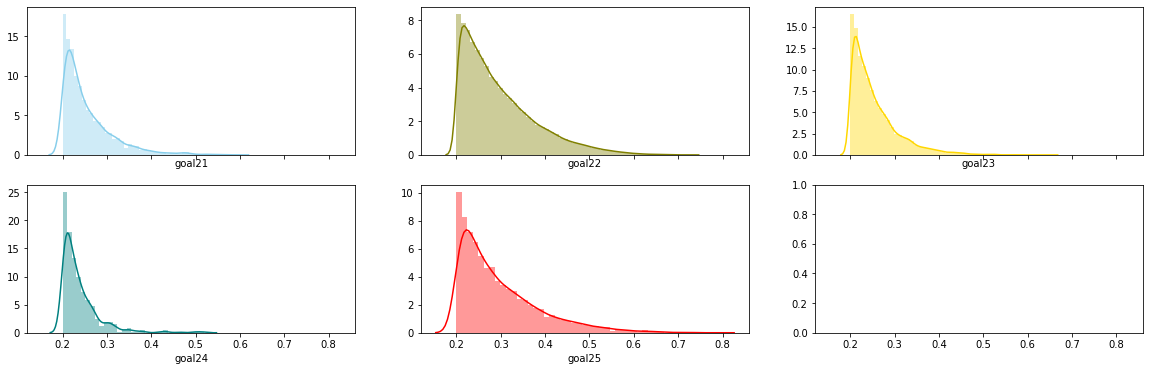

In [0]:
t=.2
f, axes = plt.subplots(2, 3, figsize=(20, 6), sharex=True)
sns.distplot( df_res["goal21"][df_res["goal21"]>t] , color="skyblue", ax=axes[0, 0])
sns.distplot( df_res["goal22"][df_res["goal22"]>t] , color="olive", ax=axes[0, 1])
sns.distplot( df_res["goal23"][df_res["goal23"]>t] , color="gold", ax=axes[0, 2])
sns.distplot( df_res["goal24"][df_res["goal24"]>t] , color="teal", ax=axes[1, 0])
sns.distplot( df_res["goal25"][df_res["goal25"]>t] , color="red", ax=axes[1, 1]);

In [0]:
df_res.to_csv( os.path.join(colab_subm_path, 'subm2_4_opt_params.csv') ) # 0.740581

## 2.5 with different hyperparameters LGB

In [0]:
colab_train_path = pathlib.Path('/content/drive/My Drive/ott_train')
Xtrain = pd.read_pickle(colab_train_path/'train.pkl')
Xtest = pd.read_pickle(colab_train_path/'test.pkl')
targets = pd.read_pickle(colab_train_path/'targets.pkl')

In [0]:
opt_goal22_1={'bagging_fraction': 0.7583949890486377, 
                     'bagging_freq': 30, 
                     'colsample_bytree': 0.5957847319300573, 
                     'feature_fraction': 0.5701469943379747, 
                     'lambda_l1': 1.6024810478481566, 
                     'lambda_l2': 0.13008005451818686, 
                     'learning_rate': 0.01, 
                     'max_bin': 82, 
                     'max_depth': 22, 
                     'min_child_samples': 384, 
                     'min_child_weight': 0.1, 
                     'min_data_in_leaf': 15, 
                    #  'n_estimators': 3420, 
                     'num_leaves': 160, 
                     'reg_alpha': 1, 
                     'reg_lambda': 20, 
                     'subsample': 0.34621894292890626}


opt_goal21_1={'bagging_fraction': 0.9654895756771754, 
                     'bagging_freq': 48, 
                     'colsample_bytree': 0.6316618472598627, 
                     'feature_fraction': 0.563032101936602, 
                     'lambda_l1': 2.3387198763414423, 
                     'lambda_l2': 1.1374415101532467, 
                     'learning_rate': 0.01, 
                     'max_bin': 44, 
                     'max_depth': 24, 
                     'min_child_samples': 428, 
                     'min_child_weight': 1, 
                     'min_data_in_leaf': 21,
                    #  'n_estimators': 2822, 
                     'num_leaves': 83, 
                     'reg_alpha': 5, 
                     'reg_lambda': 5, 
                     'subsample': 0.4380014780786996}

optuna_goal25_1={'lambda_l1': 0.07339506600611748,
                 'lambda_l2': 7.169086661812628e-06,
                 'num_leaves': 87,
                 'feature_fraction': 0.8319575690963853,
                 'bagging_fraction': 0.9962276128702263,
                 'bagging_freq': 5,
                #  'n_estimators': 3764,
                 'min_child_samples': 69 }


optuna_goal24_1={'lambda_l1': 9.391821397592286,
                 'lambda_l2': 0.00012006755910102027,
                 'num_leaves': 191,
                 'feature_fraction': 0.6023281072584363,
                 'bagging_fraction': 0.9717980271300153,
                 'bagging_freq': 1,
                #  'n_estimators': 3176,
                 'min_child_samples': 72 }


params_ = {'boosting': 'gbdt',
          'objective':'binary',
          'metric': 'auc',
          'learning_rate': 0.01, # 0.003! #0.005 #0.006 
          'num_leaves': 110, #110 #100 #150 large, but over-fitting
          'max_bin': 66,  #60 #50 # large,but slower,over-fitting
          'max_depth': 10, # deal with over-fitting
          'min_data_in_leaf': 30, # deal with over-fitting
          'min_child_samples': 20,
          'feature_fraction': 0.5,#0.5 #0.6 #0.8
          'bagging_fraction': 0.8,
          'bagging_freq': 40,#5  
          'bagging_seed': 11,
          'lambda_l1': 2,#1.3! #5 #1.2 #1
          'lambda_l2': 0.1,
           'random_state': SEED }

In [0]:
Target = namedtuple('Target', 'name params n_estimators')

goal21 = Target(name='goal21', params=opt_goal21_1, n_estimators=2822)
goal22 = Target(name='goal22', params=opt_goal22_1, n_estimators=3420)
goal23 = Target(name='goal23', params=params_, n_estimators=1000)
goal24 = Target(name='goal24', params=optuna_goal24_1, n_estimators=3176)
goal25 = Target(name='goal25', params=optuna_goal25_1, n_estimators=3764)

In [0]:
goals_cols=['goal21', 'goal22', 'goal23', 'goal24', 'goal25']
goals_source = [goal21, goal22, goal23, goal24, goal25]
df_res = pd.DataFrame()
df_scores = pd.DataFrame(index=goals_cols, columns=['avg', 'std'])

for Y_source in goals_source:

    print(f'target: {Y_source.name}')
    Y = targets[Y_source.name]

    n_fold = 10
    folds = KFold(n_splits=n_fold, shuffle=True, random_state=SEED)

    res_dict=train_model_classification(X=Xtrain, X_test=Xtest, y=Y, params=Y_source.params, folds=folds, model_type='lgb', eval_metric='auc', 
                                  columns=None, plot_feature_importance=False, model=None,
                                  verbose=10000, early_stopping_rounds=200, n_estimators=Y_source.n_estimators)
  
    df_res[Y_source.name] = res_dict['prediction'][:, 1]
    df_scores.ix[Y_source.name, 'avg'] = np.round(np.mean(res_dict['scores']), 4)
    df_scores.ix[Y_source.name, 'std'] = np.round(np.std(res_dict['scores']), 4)
    df_res.to_csv( os.path.join(colab_subm_path, f'{Y_source.name}_subm2_5_different_params.csv') )
    print(f'{Y_source.name} completed!')
    print('='*5)

target: goal21
Fold 1 started at Sun Jan 19 10:46:42 2020
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[2611]	training's binary_logloss: 0.0918673	training's auc: 0.95942	valid_1's binary_logloss: 0.140097	valid_1's auc: 0.756332
Fold 2 started at Sun Jan 19 10:52:08 2020
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[2582]	training's binary_logloss: 0.0918528	training's auc: 0.960685	valid_1's binary_logloss: 0.142165	valid_1's auc: 0.770626
Fold 3 started at Sun Jan 19 10:57:30 2020
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1606]	training's binary_logloss: 0.105915	training's auc: 0.930943	valid_1's binary_logloss: 0.133009	valid_1's auc: 0.764659
Fold 4 started at Sun Jan 19 11:01:10 2020
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[2061]	training's binary_logloss: 0.098

In [0]:
np.array(df_scores.avg).T@ np.array([0.28, 0.27, 0.09, 0.18, 0.18])

0.8148610000000001

In [0]:
df_scores

,avg,std
goal21,0.7624,0.0058
goal22,0.7572,0.0032
goal23,0.9079,0.0035
goal24,0.812,0.0079
goal25,0.9393,0.005


In [0]:
df_res.to_csv( os.path.join(colab_subm_path,'subm2_5.csv') )

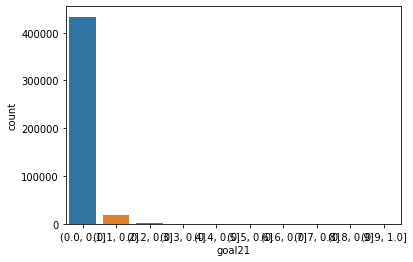

In [0]:
bins = np.linspace(0., 1.0, 11)
g21_cut = pd.cut(df_res.goal21, bins)
sns.countplot(g21_cut)

In [0]:

df_res

,goal21,goal22,goal23,goal24,goal25
0,0.031965,0.152154,0.000192,0.000136,0.002970
1,0.007021,0.029539,0.000059,0.015290,0.014993
2,0.115634,0.001854,0.000054,0.205632,0.089961
3,0.038684,0.169789,0.000122,0.033159,0.004034
4,0.011673,0.054704,0.000062,0.006715,0.037602
...,...,...,...,...,...
455006,0.077312,0.177069,0.099113,0.025256,0.000439
455007,0.023484,0.139423,0.048058,0.011652,0.004015
455008,0.046745,0.245868,0.110432,0.000124,0.000477
455009,0.041133,0.172840,0.000047,0.102221,0.000592


# TPOT

In [0]:
# !pip install tpot

In [0]:
# import joblib
import tpot
from tpot import TPOTClassifier

In [0]:
# from dask.distributed import Client
# client = Client(n_workers=4, threads_per_worker=1, processes=False)
# client

Client Scheduler: inproc://172.28.0.2/1119/1,Cluster Workers: 4 Cores: 4 Memory: 27.31 GB


In [0]:
X, X_test, Y, Y_test = train_test_split(features, label, stratify=label, test_size=0.3, random_state=SEED)

In [0]:
tpot_config = {
    
        'sklearn.ensemble.ExtraTreesRegressor': {
            'n_estimators': [100],
            'max_features': np.arange(0.05, 1.01, 0.05),
            'min_samples_split': range(2, 21),
            'min_samples_leaf': range(1, 21),
            'bootstrap': [True, False]
        },

        'sklearn.tree.DecisionTreeRegressor': {
            'max_depth': range(1, 11),
            'min_samples_split': range(2, 21),
            'min_samples_leaf': range(1, 21)
        },

        'sklearn.ensemble.RandomForestRegressor': {
            'n_estimators': [100],
            'max_features': np.arange(0.05, 1.01, 0.05),
            'min_samples_split': range(2, 21),
            'min_samples_leaf': range(1, 21),
            'bootstrap': [True, False]
        },


        # Preprocesssors
        'sklearn.preprocessing.Binarizer': {
            'threshold': np.arange(0.0, 1.01, 0.05)
        },

        'sklearn.decomposition.FastICA': {
            'tol': np.arange(0.0, 1.01, 0.05)
        },

        'sklearn.cluster.FeatureAgglomeration': {
            'linkage': ['ward', 'complete', 'average'],
            'affinity': ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']
        },

        'sklearn.preprocessing.MaxAbsScaler': {
        },

        'sklearn.preprocessing.MinMaxScaler': {
        },

        'sklearn.preprocessing.Normalizer': {
            'norm': ['l1', 'l2', 'max']
        },

        'sklearn.kernel_approximation.Nystroem': {
            'kernel': ['rbf', 'cosine', 'chi2', 'laplacian', 'polynomial', 'poly', 'linear', 'additive_chi2', 'sigmoid'],
            'gamma': np.arange(0.0, 1.01, 0.05),
            'n_components': range(1, 11)
        },

        'sklearn.decomposition.PCA': {
            'svd_solver': ['randomized'],
            'iterated_power': range(1, 11)
        },

        'sklearn.preprocessing.PolynomialFeatures': {
            'degree': [2],
            'include_bias': [False],
            'interaction_only': [False]
        },

        'sklearn.kernel_approximation.RBFSampler': {
            'gamma': np.arange(0.0, 1.01, 0.05)
        },

        'sklearn.preprocessing.RobustScaler': {
        },

        'sklearn.preprocessing.StandardScaler': {
        },

        'tpot.builtins.ZeroCount': {
        },

        'tpot.builtins.OneHotEncoder': {
            'minimum_fraction': [0.05, 0.1, 0.15, 0.2, 0.25],
            'sparse': [False],
            'threshold': [10]
        },

        # Selectors
        'sklearn.feature_selection.SelectFwe': {
            'alpha': np.arange(0, 0.05, 0.001),
            'score_func': {
                'sklearn.feature_selection.f_regression': None
            }
        },

        'sklearn.feature_selection.SelectPercentile': {
            'percentile': range(1, 100),
            'score_func': {
                'sklearn.feature_selection.f_regression': None
            }
        },

        'sklearn.feature_selection.VarianceThreshold': {
            'threshold': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2]
        },

        'sklearn.feature_selection.SelectFromModel': {
            'threshold': np.arange(0, 1.01, 0.05),
            'estimator': {
                'sklearn.ensemble.ExtraTreesRegressor': {
                    'n_estimators': [100],
                    'max_features': np.arange(0.05, 1.01, 0.05)
                }
            }
        }

    }

In [0]:
folds   = 10
# Start the TPOT regression
best_model = TPOTClassifier(use_dask=False, n_jobs=-1, config_dict=tpot_config, cv=folds, scoring='roc_auc', max_time_mins=60,
                               generations=5, population_size=20, verbosity=2, random_state=SEED) #memory='./PipelineCache',       memory='auto',
best_model.fit(X, Y)


61.60 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: ExtraTreesRegressor(input_matrix, bootstrap=False, max_features=0.15000000000000002, min_samples_leaf=6, min_samples_split=15, n_estimators=100)


TPOTClassifier(config_dict={'sklearn.cluster.FeatureAgglomeration': {'affinity': ['euclidean',
                                                                                  'l1',
                                                                                  'l2',
                                                                                  'manhattan',
                                                                                  'cosine'],
                                                                     'linkage': ['ward',
                                                                                 'complete',
                                                                                 'average']},
                            'sklearn.decomposition.FastICA': {'tol': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])},
                            'sklearn.decomposition.PC

In [0]:
# Export the TPOT pipeline if you want to use it for anything later
if os.path.exists('./Exported Pipelines'):
    pass
else:
    os.mkdir('./Exported Pipelines')
best_model.export('./Exported Pipelines/' + ticker_input + '-prediction-pipeline.py')


In [0]:
# scale up: Increase the TPOT parameters like population_size, generations
tp = TPOTClassifier(
    generations=5,
    population_size=20,
    cv=5,
    n_jobs=-1,
    random_state=SEED,
    verbosity=3, max_time_mins=60, scoring='roc_auc',
    config_dict=tpot.config.classifier_config_dict_light,
    use_dask=False)

In [0]:
# perform the fit in this context manager
# with joblib.parallel_backend("dask"):
#     tp.fit(X, Y)

In [0]:
tp.fit(X, Y)

31 operators have been imported by TPOT.


Skipped pipeline #6 due to time out. Continuing to the next pipeline.

5.10 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.


TPOTClassifier(config_dict=None, crossover_rate=0.1, cv=3,
               disable_update_check=False, early_stop=None, generations=5,
               max_eval_time_mins=5, max_time_mins=5, memory=None,
               mutation_rate=0.9, n_jobs=-1, offspring_size=None,
               periodic_checkpoint_folder=None, population_size=20,
               random_state=17, scoring='roc_auc', subsample=1.0, template=None,
               use_dask=False, verbosity=3, warm_start=False)

In [0]:
# set parameters
gens = 2                                              # 100 gens is default, takes 2 days on 32 cores
pop_size = 5                                          # population size per gen
max_time_mins = None                                  # cap on training time

# Instantiate tpot classifier
tpot = TPOTClassifier(generations=gens,               # number of generations to run
                      population_size=pop_size,       # number of models in a generation
                      max_time_mins=max_time_mins,    # maximum time to train
                      scoring='roc_auc',              # score with respect to roc_auc
                      verbosity=2,                    # verbosity of the model 
                      n_jobs=-1,                      # this tells the model to use as many cores as it can find!
                      random_state=2017)              # random state

In [0]:
tpot.fit(X, Y)

Generation 1 - Current best internal CV score: 0.6775898058168919
Generation 2 - Current best internal CV score: 0.6775898058168919

Best pipeline: GradientBoostingClassifier(input_matrix, learning_rate=0.001, max_depth=9, max_features=0.25, min_samples_leaf=8, min_samples_split=10, n_estimators=100, subsample=0.7000000000000001)


TPOTClassifier(config_dict=None, crossover_rate=0.1, cv=5,
               disable_update_check=False, early_stop=None, generations=2,
               max_eval_time_mins=5, max_time_mins=None, memory=None,
               mutation_rate=0.9, n_jobs=-1, offspring_size=None,
               periodic_checkpoint_folder=None, population_size=5,
               random_state=2017, scoring='roc_auc', subsample=1.0,
               template=None, use_dask=False, verbosity=2, warm_start=False)

In [0]:
print(f"Test roc auc score:\t{tpot.score(X_test, Y_test)}")

Test roc auc score:	0.6748026595079117


In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import Binarizer, Normalizer
from tpot.builtins import StackingEstimator
from xgboost import XGBClassifier

model = make_pipeline(
    StackingEstimator(estimator=LogisticRegression(C=5.0, dual=False, penalty="l2")),
    StackingEstimator(estimator=XGBClassifier(learning_rate=1.0, max_depth=1, min_child_weight=12, n_estimators=100, nthread=1, subsample=0.7500000000000001)),
    Normalizer(norm="max"),
    StackingEstimator(estimator=LogisticRegression(C=0.5, dual=False, penalty="l1")),
    StackingEstimator(estimator=LogisticRegression(C=0.5, dual=False, penalty="l1")),
    Binarizer(threshold=0.25),
    XGBClassifier(learning_rate=0.001, max_depth=1, min_child_weight=10, n_estimators=100, nthread=1, subsample=1.0)
)

In [0]:
model.fit(X, Y)

Pipeline(memory=None,
         steps=[('stackingestimator-1',
                 StackingEstimator(estimator=LogisticRegression(C=5.0,
                                                                class_weight=None,
                                                                dual=False,
                                                                fit_intercept=True,
                                                                intercept_scaling=1,
                                                                l1_ratio=None,
                                                                max_iter=100,
                                                                multi_class='warn',
                                                                n_jobs=None,
                                                                penalty='l2',
                                                                random_state=None,
                                                            

In [0]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

In [0]:
# export_best_pipeline = False

# if export_best_pipeline:
#     tpot.export(TPOT_DIR / 'tpot_idn_pipeline.py')

In [0]:
y_prob_series = pd.Series(y_prob)

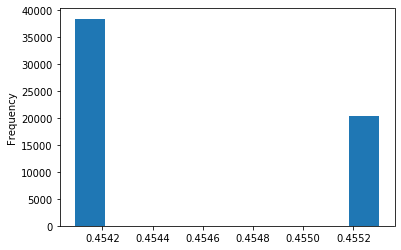

In [0]:
y_prob_series.plot.hist()

In [0]:
exctracted_best_model = tp.fitted_pipeline_.steps[-1][1]

In [0]:
exctracted_best_model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=10,
              min_child_weight=18, missing=None, n_estimators=100, n_jobs=1,
              nthread=1, objective='binary:logistic', random_state=17,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.7500000000000001, verbosity=1)

In [0]:
exctracted_best_model.fit(X, Y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=10,
              min_child_weight=18, missing=None, n_estimators=100, n_jobs=1,
              nthread=1, objective='binary:logistic', random_state=17,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.7500000000000001, verbosity=1)

In [0]:
predictions = exctracted_best_model.predict(X_test)

In [0]:
print(tp.score(X_test, Y_test))
# pipeline_optimizer.export('tpot_exported_pipeline.py')

0.9778635428532567


In [0]:
print(tp.score(X_test, Y_test))

0.665772723685386


# Make features

In [0]:
def aggregate_trans(data, group_col, prefix):  
    agg_func = {
        'NDAYS_FROM_LAST': ['median', 'mean', 'std'], #num_trans
        'field12': ['sum', 'mean','median', 'max', 'min', 'std'],
        'field13': ['sum', 'mean','median', 'max', 'min', 'std'],
        'field17': ['sum', 'mean','median', 'max', 'min', 'std'],
        'DAYS_BEFORE_DEPART': ['sum', 'mean','median', 'max', 'min', 'std'],
        'field19': ['sum', 'mean','median', 'max', 'min', 'std', 'nunique'],
        'field22': ['sum', 'mean','median', 'max', 'min', 'std'],
        'field25': ['sum', 'mean','median', 'max', 'min', 'std'],
        'field26': ['sum', 'mean','median', 'max', 'min', 'std']
        # 'field1': ['sum', 'mean', 'median', 'max', 'min', 'std', 'nunique'],
        # 'field14': ['sum', 'mean', 'median', 'max', 'min', 'std', 'nunique']
    }    
    agg_trans = data.groupby(group_col).agg(agg_func)
    agg_trans.columns = [prefix + '_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)
    
    return agg_trans
    

In [0]:
# df = df.merge(aggregate_trans(df, ['YEAR', 'MONTH_BUY'], 'MB_'), how='left', on=['YEAR', 'MONTH_BUY'])
# df = df.merge(aggregate_trans(df, ['YEAR', 'HOUR_OF_BUY'], 'HOB_'), how='left', on=['YEAR', 'HOUR_OF_BUY'])
# df = df.merge(aggregate_trans(df, ['YEAR', 'DOW_BUY'], 'DOWB_'), how='left', on=['YEAR', 'DOW_BUY'])

df = df.merge(aggregate_trans(df, ['YEAR', 'MONTH_DEPART'], 'MD_'), how='left', on=['YEAR', 'MONTH_DEPART'])
df = df.merge(aggregate_trans(df, ['YEAR', 'HOUR_DEPART'], 'HD_'), how='left', on=['YEAR', 'HOUR_DEPART'])
df = df.merge(aggregate_trans(df, ['YEAR', 'DOW_DEPART'], 'DOWD_'), how='left', on=['YEAR', 'DOW_DEPART'])

In [0]:
df = df.merge(aggregate_trans(df, ['field26', 'field27'], 'F26F27_'), how='left', on=['field26', 'field27'])
df = df.merge(aggregate_trans(df, ['field1', 'field14'], 'F1F14_'), how='left', on=['field1', 'field14'])
df.shape

(196056, 305)

In [0]:
def feature_engineering(df):

  df['DIFF_H']=abs(df['HOUR_DEPART']-df['HOUR_OF_BUY']).astype('int32')
  df['DIFF_M']=abs(df['MONTH_DEPART']-df['MONTH_BUY']).astype('int32')
  df['CHILD'] = df.TOTAL_TICKETS- df.TICKET_ADULT

  df['f14_id_median'] = df.userid.map(df.groupby('userid')['field14'].median().fillna(-1))
  df['f1_id_median'] = df.userid.map(df.groupby('userid')['field1'].median().fillna(-1))
  df['f1_id_std'] = df.userid.map(df.groupby('userid')['field1'].std().fillna(-1))
  df['f14_id_std'] = df.userid.map(df.groupby('userid')['field14'].std().fillna(-1))
  df['f26_id_median'] = df.userid.map(df.groupby('userid')['field26'].median().fillna(-1))
  df['f27_id_median'] = df.userid.map(df.groupby('userid')['field27'].median().fillna(-1))
  df['f26_id_std'] = df.userid.map(df.groupby('userid')['field26'].std().fillna(-1))
  df['f27_id_std'] = df.userid.map(df.groupby('userid')['field27'].std().fillna(-1))
  df['DAYS_BEFORE_DEPART_id_median'] = df.userid.map(df.groupby('userid')['DAYS_BEFORE_DEPART'].median().fillna(-1))
  df['DAYS_BEFORE_DEPART_id_std'] = df.userid.map(df.groupby('userid')['DAYS_BEFORE_DEPART'].std().fillna(-1))
  df['NDAYS_FROM_LAST_id_median'] = df.userid.map(df.groupby('userid')['NDAYS_FROM_LAST'].median().fillna(-1))
  df['NDAYS_FROM_LAST_id_std'] = df.userid.map(df.groupby('userid')['NDAYS_FROM_LAST'].std().fillna(-1))
  df['ORDER_OF_BUY_id_median'] = df.userid.map(df.groupby('userid')['ORDER_OF_BUY'].median().fillna(-1))
  df['ORDER_OF_BUY_id_std'] = df.userid.map(df.groupby('userid')['ORDER_OF_BUY'].std().fillna(-1))
  df['field13_id_median'] = df.userid.map(df.groupby('userid')['field13'].median().fillna(-1))
  df['field13_id_std'] = df.userid.map(df.groupby('userid')['field13'].std().fillna(-1))
  df['field26_id_median'] = df.userid.map(df.groupby('userid')['field26'].median().fillna(-1))
  df['field26_id_std'] = df.userid.map(df.groupby('userid')['field26'].std().fillna(-1))
  df['field19_id_median'] = df.userid.map(df.groupby('userid')['field19'].median().fillna(-1))
  df['field19_id_std'] = df.userid.map(df.groupby('userid')['field19'].std().fillna(-1))

  df = add_sem(df, group_col='userid', used_col=['field1'])
  df = add_sem(df, group_col='userid', used_col=['field14'])
  df = add_sem(df, group_col='userid', used_col=['field26'])
  df = add_sem(df, group_col='userid', used_col=['field27'])
  df = add_sem(df, group_col='userid', used_col=['field12'])
  df = add_sem(df, group_col='userid', used_col=['NDAYS_FROM_LAST'])
  df = add_sem(df, group_col='userid', used_col=['field13'])
  df = add_sem(df, group_col='userid', used_col=['field22'])
  df = add_sem(df, group_col='userid', used_col=['field25'])

  make_conj(df, 'field1', 'field14')
  make_conj(df, 'field26', 'field27')
 
  return reduce_mem_usage(df)


In [0]:
df = feature_engineering(df)

Mem. usage decreased to 61.70 Mb (5.4% reduction)


In [0]:
df[:3]

,orderid,userid,NDAYS_FROM_LAST,field1,MONTH_BUY,MONTH_DEPART,ORDER_OF_BUY,field5,field6,field7,field8,TICKET_CHILD_1Y,field10,HOUR_OF_BUY,field12,field13,field14,TOTAL_TICKETS,DAYS_BEFORE_DEPART,field17,DOW_BUY,field19,DOW_DEPART,YEAR,field22,HOUR_DEPART,TICKET_ADULT,field25,field26,field27,TICKET_CHILD_4Y,QUARTER,indicator_goal21,indicator_goal22,indicator_goal23,indicator_goal24,indicator_goal25,goal21,goal22,goal23,goal24,goal25,goal1,USR_CNT,INDICATOR_CNT,DIFF_H,DIFF_M,CHILD,f14_id_median,f1_id_median,f1_id_std,f14_id_std,f26_id_median,f27_id_median,f26_id_std,f27_id_std,DAYS_BEFORE_DEPART_id_median,DAYS_BEFORE_DEPART_id_std,NDAYS_FROM_LAST_id_median,NDAYS_FROM_LAST_id_std,ORDER_OF_BUY_id_median,ORDER_OF_BUY_id_std,field13_id_median,field13_id_std,field26_id_median,field26_id_std,field19_id_median,field19_id_std,field1_sem,field14_sem,field26_sem,field27_sem,field12_sem,NDAYS_FROM_LAST_sem,field13_sem,field22_sem,field25_sem,field1_field14,field26_field27
0,0,7458,0,-0.626508,11,12,1,1,0,1,1,0,0,9,5,20,-0.661308,1,4,1,4,1,1,1,1,15,1,1,2,1,0,4,1,1,0,1,1,0,1,0,0,0,0,1,0.799805,6,1,0,-0.661308,-0.626508,-1.000000,-1.000000,2.0,1.0,-1.000000,-1.000000,4.0,-1.000000,0.0,-1.000000,1.0,-1.000000,20.0,-1.000000,2.0,-1.000000,1.0,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,106,20
1,1,33232,144,-0.393794,5,7,2,0,0,0,1,0,0,21,125,3,-0.101043,1,57,1,5,1,6,0,121,15,1,41,3,1,0,2,1,1,0,1,0,0,0,0,0,0,0,2,0.600098,6,2,0,-0.171076,-0.393794,0.000000,0.099042,7.5,2.0,6.363961,1.414214,48.5,12.020815,72.0,101.823376,1.5,0.707107,23.5,28.991378,7.5,6.363961,1.5,0.707107,0.000000,0.070033,4.5,1.0,46.0,72.0,20.5,18.5,5.5,69,21
2,2,83136,134,-0.548937,2,3,2,0,0,1,1,0,1,7,4,3,-0.661308,1,4,1,2,3,6,0,17,14,1,1,11,7,0,1,1,1,0,1,1,0,0,0,0,0,0,2,0.799805,7,1,0,-0.661308,-0.587722,0.054851,0.000000,11.0,7.0,0.000000,0.000000,3.5,0.707107,67.0,94.752309,1.5,0.707107,4.0,1.414214,11.0,0.000000,2.0,1.414214,0.038786,0.000000,0.0,0.0,5.0,67.0,1.0,8.0,0.0,95,1


In [0]:
gr = ['YEAR', 'MONTH_DEPART', 'DOW_DEPART', 'field27']
gr2 = ['field1', 'field14']
gr3 = ['field26', 'field27']
# df.groupby(gr3)['indicator_goal21'].sum()
pd.concat([df.userid.map(df.groupby('userid')[ig].mean()) for ig in indicator_cols], axis=1)

,userid,userid,userid,userid,userid
0,1.0,1.0,0.000000,1.000000,1.000000
1,1.0,1.0,0.000000,1.000000,0.000000
2,1.0,1.0,0.500000,1.000000,1.000000
3,1.0,1.0,0.333333,1.000000,1.000000
4,1.0,1.0,0.000000,0.000000,1.000000
...,...,...,...,...,...
196051,1.0,1.0,0.250000,0.250000,0.250000
196052,1.0,1.0,0.000000,0.500000,0.500000
196053,1.0,1.0,1.000000,1.000000,1.000000
196054,1.0,1.0,0.000000,0.666667,0.666667


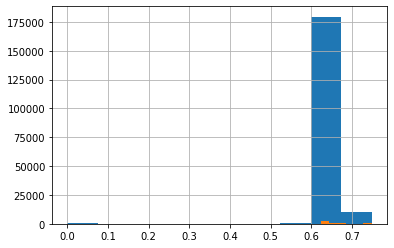

In [0]:
df_indicator.query("goal24 == 0")[[x + '_field14' for x in indicator_cols]].iloc[:, 3].hist()
df_indicator.query("goal24 == 1")[[x + '_field14' for x in indicator_cols]].iloc[:, 3].hist()

In [0]:
def add_IG_agg(df):

  temp_df = df.copy()
  temp = pd.concat([temp_df.userid.map(temp_df.groupby('userid')[ig].mean()) for ig in indicator_cols], axis=1)
  temp.columns = [x + '_user_avg' for x in indicator_cols]

  return (temp)

df_indicator = pd.concat([df, add_IG_agg(df)], axis=1)

# goal21 CV mean score: 0.7464, std: 0.0030
# goal22 CV mean score: 0.7416, std: 0.0026
# goal23 CV mean score: 0.9025, std: 0.0023
# goal24 CV mean score: 0.8103, std: 0.0045
# goal25 CV mean score: 0.9391, std: 0.0016

In [0]:
def add_IG_agr(df):

  temp_df = df.copy()
  temp = pd.concat([temp_df.field1.map(temp_df.groupby('field1')[ig].mean()) for ig in indicator_cols], axis=1)
  temp.columns = [x + '_field14' for x in indicator_cols]

  return (temp)

df_indicator = pd.concat([df, add_IG_agr(df)], axis=1)

In [0]:
def add_IG_mult(df, gr_col=['DOW_DEPART']):

  temp_df = df.copy()
  temp_df = add_aggregate(temp_df, group_col=gr_col, used_col='userid', func=unique_cnt, suffix='unique_cnt')
  div_col = 'userid_unique_cnt'

  temp_df = add_aggregate(temp_df, group_col=gr_col, used_col='indicator_goal21', func=sum, suffix='sum')
  temp_df['INDICATOR21_AGG_norm'] = temp_df['indicator_goal21_sum']/temp_df[div_col]
  temp_df = add_aggregate(temp_df, group_col=gr_col, used_col='indicator_goal22', func=sum, suffix='sum')
  temp_df['INDICATOR22_AGG_norm'] = temp_df['indicator_goal22_sum']/temp_df[div_col]
  temp_df = add_aggregate(temp_df, group_col=gr_col, used_col='indicator_goal23', func=sum, suffix='sum')
  temp_df['INDICATOR23_AGG_norm'] = temp_df['indicator_goal23_sum']/temp_df[div_col]
  temp_df = add_aggregate(temp_df, group_col=gr_col, used_col='indicator_goal24', func=sum, suffix='sum')
  temp_df['INDICATOR24_AGG_norm'] = temp_df['indicator_goal24_sum']/temp_df[div_col]
  temp_df = add_aggregate(temp_df, group_col=gr_col, used_col='indicator_goal25', func=sum, suffix='sum')
  temp_df['INDICATOR25_AGG_norm'] = temp_df['indicator_goal25_sum']/temp_df[div_col]

  return (temp_df.filter(regex='AGG_norm'))

In [0]:
df_indicator = pd.concat([df, add_IG_mult(df, gr_col=['DOW_DEPART'])], axis=1)

In [0]:
df_indicator[:3]

,orderid,userid,NDAYS_FROM_LAST,field1,MONTH_BUY,MONTH_DEPART,ORDER_OF_BUY,field5,field6,field7,field8,TICKET_CHILD_1Y,field10,HOUR_OF_BUY,field12,field13,field14,TOTAL_TICKETS,DAYS_BEFORE_DEPART,field17,DOW_BUY,field19,DOW_DEPART,YEAR,field22,HOUR_DEPART,TICKET_ADULT,field25,field26,field27,TICKET_CHILD_4Y,QUARTER,indicator_goal21,indicator_goal22,indicator_goal23,indicator_goal24,indicator_goal25,goal21,goal22,goal23,goal24,goal25,goal1,USR_CNT,INDICATOR_CNT,DIFF_H,DIFF_M,CHILD,f14_id_median,f1_id_median,f1_id_std,f14_id_std,f26_id_median,f27_id_median,f26_id_std,f27_id_std,DAYS_BEFORE_DEPART_id_median,DAYS_BEFORE_DEPART_id_std,NDAYS_FROM_LAST_id_median,NDAYS_FROM_LAST_id_std,ORDER_OF_BUY_id_median,ORDER_OF_BUY_id_std,field13_id_median,field13_id_std,field26_id_median,field26_id_std,field19_id_median,field19_id_std,field1_sem,field14_sem,field26_sem,field27_sem,field12_sem,NDAYS_FROM_LAST_sem,field13_sem,field22_sem,field25_sem,field1_field14,field26_field27,INDICATOR21_AGG_norm,INDICATOR22_AGG_norm,INDICATOR23_AGG_norm,INDICATOR24_AGG_norm,INDICATOR25_AGG_norm
0,0,7458,0,-0.626508,11,12,1,1,0,1,1,0,0,9,5,20,-0.661308,1,4,1,4,1,1,1,1,15,1,1,2,1,0,4,1,1,0,1,1,0,1,0,0,0,0,1,0.799805,6,1,0,-0.661308,-0.626508,-1.000000,-1.000000,2.0,1.0,-1.000000,-1.000000,4.0,-1.000000,0.0,-1.000000,1.0,-1.000000,20.0,-1.000000,2.0,-1.000000,1.0,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,106,20,1.203539,1.183902,0.428010,0.813552,0.788045
1,1,33232,144,-0.393794,5,7,2,0,0,0,1,0,0,21,125,3,-0.101043,1,57,1,5,1,6,0,121,15,1,41,3,1,0,2,1,1,0,1,0,0,0,0,0,0,0,2,0.600098,6,2,0,-0.171076,-0.393794,0.000000,0.099042,7.5,2.0,6.363961,1.414214,48.5,12.020815,72.0,101.823376,1.5,0.707107,23.5,28.991378,7.5,6.363961,1.5,0.707107,0.000000,0.070033,4.5,1.0,46.0,72.0,20.5,18.5,5.5,69,21,1.191231,1.169733,0.428602,0.763266,0.774865
2,2,83136,134,-0.548937,2,3,2,0,0,1,1,0,1,7,4,3,-0.661308,1,4,1,2,3,6,0,17,14,1,1,11,7,0,1,1,1,0,1,1,0,0,0,0,0,0,2,0.799805,7,1,0,-0.661308,-0.587722,0.054851,0.000000,11.0,7.0,0.000000,0.000000,3.5,0.707107,67.0,94.752309,1.5,0.707107,4.0,1.414214,11.0,0.000000,2.0,1.414214,0.038786,0.000000,0.0,0.0,5.0,67.0,1.0,8.0,0.0,95,1,1.191231,1.169733,0.428602,0.763266,0.774865


In [0]:
pd.crosstab([df.field27, df.indicator_goal22], df.goal22)

goal22                         0      1
field27 indicator_goal22               
1       0                   3264      0
        1                 109765  27352
2       0                     31      0
        1                   1206    365
3       0                    417      0
        1                  37409   2435
4       0                    143      0
        1                   1958    803
5       0                     12      0
        1                   3342    816
6       0                     32      0
        1                   1196    349
7       0                     91      0
        1                   4139    931

## New features

In [0]:
# df['WEEKS_BEFORE_DEPART'] = (df.DAYS_BEFORE_DEPART / 7).astype('float32')
# df['WEEKEND_DEPART'] = (df.DOW_DEPART >=5).astype('int16')

# df['NDAYS_LAST_NEXT'] = (df.NDAYS_FROM_LAST+df.DAYS_BEFORE_DEPART).astype('int32')
# df['TODAY']=(df.DAYS_BEFORE_DEPART==0).astype('int32')
df['DIFF_H']=abs(df['HOUR_DEPART']-df['HOUR_OF_BUY']).astype('int32')
df['DIFF_M']=abs(df['MONTH_DEPART']-df['MONTH_BUY']).astype('int32')
# df['NUM_MONTH_DEPART'] = (df.MONTH_DEPART-12) *(df.YEAR==0) + (df.MONTH_DEPART )*(df.YEAR==1)
# df['NUM_MONTH_BUY'] = (df.MONTH_BUY-12) *(df.YEAR==0) + (df.MONTH_BUY )*(df.YEAR==1)
# df['DIFF_NUM_MONTH'] = abs(df['NUM_MONTH_DEPART'] - df['NUM_MONTH_BUY'])
df['CHILD'] = df.TOTAL_TICKETS- df.TICKET_ADULT

# df['DIFF_MONTH_DEPART&MONTH_OF_BUY_norm'] = df['DIFF_MONTH_DEPART&MONTH_OF_BUY']#.values / (np.pi ** np.e)
# df['DIFF_HOUR_DEPART&HOUR_OF_BUY_norm'] = df['DIFF_HOUR_DEPART&HOUR_OF_BUY']#.values / (np.pi ** np.e)
# df['DIFF_NUM_MONTH_norm'] = df['DIFF_NUM_MONTH']#.values / (np.pi ** np.e)


# df['INDICATOR_USR_AVG'] = df.userid.map(df.groupby('userid')[indicator_cols].sum().mean(axis=1))
# indicators_group = df.groupby('userid')[indicator_cols]
# df_sum=indicators_group.sum().copy()
# df_indicators_avg=df_sum.div(indicators_group.sum().sum(axis=1), axis=0)
# df_indicators_avg.columns = ['INDICATOR21_TOTAL_AVG', 'INDICATOR22_TOTAL_AVG', 'INDICATOR23_TOTAL_AVG', 
#                              'INDICATOR24_TOTAL_AVG', 'INDICATOR25_TOTAL_AVG']
# df = df.merge(df_indicators_avg, how='left', on='userid')

# make_conj(df, 'field1', 'field14')
# make_conj(df, 'field26', 'field27')

# del indicators_group, df_sum, df_indicators_avg
gc.collect()

# "MONTH_DEPART", "field12", percentiles, mean, median and so forth
# 'MONTH_BUY', "DAYS_BEFORE_DEPART" percentiles, mean median...
# 'MONTH_BUY', "field13", 'field22', 'field25', 'field26', 'NDAYS_FROM_LAST', 'USR_CNT' percentiles, mean median...
# сравнение статистик мес к мес за 2 года
# field5==0 YEAR==0 нет goals == 1 -> conj field5 & YEAR, field26&field27
# 'field5', "TICKET_ADULT" statistics
# DOW_BUY: 'field12' 13 22, field25!, NDAYS_LAST_NEXT
# HOUR_DEPART: DAYS_BEFORE_DEPART, field12!, 13, 14, field17 field22 field25! 26 NDAYS_FROM_LAST NDAYS_LAST_NEXT
# field27: NDAYS_LAST_NEXT, NDAYS_FROM_LAST, field25! 22 field13 field12 DAYS_BEFORE_DEPART

8

In [0]:
df['f14_id_median'] = df.userid.map(df.groupby('userid')['field14'].median().fillna(-1))
df['f1_id_median'] = df.userid.map(df.groupby('userid')['field1'].median().fillna(-1))

df['f1_id_std'] = df.userid.map(df.groupby('userid')['field1'].std().fillna(-1))
df['f14_id_std'] = df.userid.map(df.groupby('userid')['field14'].std().fillna(-1))

df['f26_id_median'] = df.userid.map(df.groupby('userid')['field26'].median().fillna(-1))
df['f27_id_median'] = df.userid.map(df.groupby('userid')['field27'].median().fillna(-1))

df['f26_id_std'] = df.userid.map(df.groupby('userid')['field26'].std().fillna(-1))
df['f27_id_std'] = df.userid.map(df.groupby('userid')['field27'].std().fillna(-1))

In [0]:
df = add_sem(df, group_col='userid', used_col=['field1'], prefix='f1')
df = add_sem(df, group_col='userid', used_col=['field14'], prefix='f14')

df = add_sem(df, group_col='userid', used_col=['field26'], prefix='f26')
df = add_sem(df, group_col='userid', used_col=['field27'], prefix='f27')

In [0]:
make_conj(df, 'field1', 'field14')
make_conj(df, 'field26', 'field27')

In [0]:
from collections import Counter
# c = Counter
# c(df.query("userid == 113896").HOUR_DEPART).most_common()[0][0]

23

In [0]:
# grouped_mult_id = df.query("USR_CNT > 1").groupby('userid')
# funct = lambda x: Counter(x).most_common()[0][0]

# df['freq_HOB'] = df.userid.map(grouped_mult_id.HOUR_OF_BUY.apply(funct).fillna(-1)) # CV mean score: 0.6893, std: 0.0046.

In [0]:
# df.freq_HOB.fillna(-1, inplace=True)

In [0]:
# df['freq_HD'] = df.userid.map(grouped_mult_id.HOUR_DEPART.apply(funct)).fillna(-1) # CV mean score: 0.6893, std: 0.0048

In [0]:
# df['f12_id_median'] = df.userid.map(df.groupby('userid')['field12'].median().fillna(-1))
# df['f12_id_std'] = df.userid.map(df.groupby('userid')['field12'].std().fillna(-1)) # CV mean score: 0.6893, std: 0.0052

In [0]:
df = add_sem(df, group_col='userid', used_col=['field12'], prefix='f12') # CV mean score: 0.6901, std: 0.0050

In [0]:
df['DAYS_BEFORE_DEPART_id_median'] = df.userid.map(df.groupby('userid')['DAYS_BEFORE_DEPART'].median().fillna(-1))
df['DAYS_BEFORE_DEPART_id_std'] = df.userid.map(df.groupby('userid')['DAYS_BEFORE_DEPART'].std().fillna(-1))

# CV mean score: 0.6930, std: 0.0051
# CV mean score: 0.6933, std: 0.0046 without freq_HOB, freq_HD

In [0]:
# df = add_sem(df, group_col='userid', used_col=['DAYS_BEFORE_DEPART'], prefix='DAYS_BEFORE_DEPART')
# df.drop(columns='DAYS_BEFORE_DEPART_sem_DAYS_BEFORE_DEPART', axis=1, inplace=True)

In [0]:
df = add_sem(df, group_col='userid', used_col=['NDAYS_FROM_LAST'], prefix='_') # CV mean score: 0.6947, std: 0.0039

In [0]:
df['NDAYS_FROM_LAST_id_median'] = df.userid.map(df.groupby('userid')['NDAYS_FROM_LAST'].median().fillna(-1))
df['NDAYS_FROM_LAST_id_std'] = df.userid.map(df.groupby('userid')['NDAYS_FROM_LAST'].std().fillna(-1))
# CV mean score: 0.6977, std: 0.0049

In [0]:
# df = add_sem(df, group_col='userid', used_col=['ORDER_OF_BUY'], prefix='_') # CV mean score: 0.6978, std: 0.0045
# df.drop(columns='ORDER_OF_BUY_sem__', axis=1, inplace=True)

In [0]:
df['ORDER_OF_BUY_id_median'] = df.userid.map(df.groupby('userid')['ORDER_OF_BUY'].median().fillna(-1))
df['ORDER_OF_BUY_id_std'] = df.userid.map(df.groupby('userid')['ORDER_OF_BUY'].std().fillna(-1))

# CV mean score: 0.6977, std: 0.0049

In [0]:
df = add_sem(df, group_col='userid', used_col=['field13'], prefix='_') # CV mean score: 0.7001, std: 0.0054

In [0]:
df['field13_id_median'] = df.userid.map(df.groupby('userid')['field13'].median().fillna(-1))
df['field13_id_std'] = df.userid.map(df.groupby('userid')['field13'].std().fillna(-1))

# CV mean score: 0.7008, std: 0.0053

In [0]:
# df = add_sem(df, group_col='userid', used_col=['field17'], prefix='_') # CV mean score: 0.7006, std: 0.0050
# df.drop(columns='field17_sem__', axis=1, inplace=True)

In [0]:
# df['field17_id_median'] = df.userid.map(df.groupby('userid')['field17'].median().fillna(-1))
# df['field17_id_std'] = df.userid.map(df.groupby('userid')['field17'].std().fillna(-1))
# CV mean score: 0.6997, std: 0.0045
# df.drop(columns='field17_id_median', axis=1, inplace=True)
# df.drop(columns='field17_id_std', axis=1, inplace=True)

In [0]:
df = add_sem(df, group_col='userid', used_col=['field22'], prefix='_') # CV mean score: 0.7010, std: 0.0050

In [0]:
# df['field22_id_median'] = df.userid.map(df.groupby('userid')['field22'].median().fillna(-1))
# df['field22_id_std'] = df.userid.map(df.groupby('userid')['field22'].std().fillna(-1))

# CV mean score: 0.7007, std: 0.0044
# df.drop(columns=['field22_id_median', 'field22_id_std'], axis=1, inplace=True)

In [0]:
df = add_sem(df, group_col='userid', used_col=['field25'], prefix='_') # CV mean score: 0.7014, std: 0.0044

In [0]:
# df['field25_id_median'] = df.userid.map(df.groupby('userid')['field25'].median().fillna(-1))
# df['field25_id_std'] = df.userid.map(df.groupby('userid')['field25'].std().fillna(-1))
# CV mean score: 0.7009, std: 0.0043
# df.drop(columns=['field25_id_median', 'field25_id_std'], axis=1, inplace=True)

In [0]:
# df = add_sem(df, group_col='userid', used_col=['field26'], prefix='_') # CV mean score: 0.7002, std: 0.0041
# df.drop(columns=['field26_sem__'], axis=1, inplace=True)

In [0]:
df['field26_id_median'] = df.userid.map(df.groupby('userid')['field26'].median().fillna(-1))
df['field26_id_std'] = df.userid.map(df.groupby('userid')['field26'].std().fillna(-1))
# CV mean score: 0.7007, std: 0.0038

In [0]:
# df = add_sem(df, group_col='userid', used_col=['field19'], prefix='_') # CV mean score: 0.7003, std: 0.0049
# df.drop(columns=['field19_sem__'], axis=1, inplace=True)

In [0]:
df['field19_id_median'] = df.userid.map(df.groupby('userid')['field19'].median().fillna(-1))
df['field19_id_std'] = df.userid.map(df.groupby('userid')['field19'].std().fillna(-1))
# CV mean score: 0.7016, std: 0.0049

In [0]:
df[:3]

,orderid,userid,NDAYS_FROM_LAST,field1,MONTH_BUY,MONTH_DEPART,ORDER_OF_BUY,field5,field6,field7,field8,TICKET_CHILD_1Y,field10,HOUR_OF_BUY,field12,field13,field14,TOTAL_TICKETS,DAYS_BEFORE_DEPART,field17,DOW_BUY,field19,DOW_DEPART,YEAR,field22,HOUR_DEPART,TICKET_ADULT,field25,field26,field27,TICKET_CHILD_4Y,QUARTER,indicator_goal21,indicator_goal22,indicator_goal23,indicator_goal24,indicator_goal25,goal21,goal22,goal23,goal24,goal25,goal1,USR_CNT,INDICATOR_CNT,DIFF_H,DIFF_M,CHILD,f14_id_median,f1_id_median,f1_id_std,f14_id_std,f26_id_median,f27_id_median,f26_id_std,f27_id_std,field1_sem_f1,field14_sem_f14,field26_sem_f26,field27_sem_f27,field1_field14,field26_field27,field12_sem_f12,DAYS_BEFORE_DEPART_id_median,DAYS_BEFORE_DEPART_id_std,NDAYS_FROM_LAST_sem__,NDAYS_FROM_LAST_id_median,NDAYS_FROM_LAST_id_std,ORDER_OF_BUY_id_median,ORDER_OF_BUY_id_std,field13_sem__,field13_id_median,field13_id_std,field19_id_median,field19_id_std,field22_sem__,field26_id_median,field26_id_std,field25_sem__
0,0,7458,0,-0.626508,11,12,1,1,0,1,1,0,0,9,5,20,-0.661308,1,4,1,4,1,1,1,1,15,1,1,2,1,0,4,1,1,0,1,1,0,1,0,0,0,0,1,0.799805,6,1,0,-0.661308,-0.626508,-1.000000,-1.000000,2.0,1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,106,20,-1.0,4.0,-1.000000,-1.0,0.0,-1.000000,1.0,-1.000000,-1.0,20.0,-1.000000,1.0,-1.000000,-1.0,2.0,-1.000000,-1.0
1,1,33232,144,-0.393794,5,7,2,0,0,0,1,0,0,21,125,3,-0.101043,1,57,1,5,1,6,0,121,15,1,41,3,1,0,2,1,1,0,1,0,0,0,0,0,0,0,2,0.600098,6,2,0,-0.171076,-0.393794,0.000000,0.099042,7.5,2.0,6.363961,1.414214,0.000000,0.070033,4.5,1.0,69,21,46.0,48.5,12.020815,72.0,72.0,101.823376,1.5,0.707107,20.5,23.5,28.991378,1.5,0.707107,18.5,7.5,6.363961,5.5
2,2,83136,134,-0.548937,2,3,2,0,0,1,1,0,1,7,4,3,-0.661308,1,4,1,2,3,6,0,17,14,1,1,11,7,0,1,1,1,0,1,1,0,0,0,0,0,0,2,0.799805,7,1,0,-0.661308,-0.587722,0.054851,0.000000,11.0,7.0,0.000000,0.000000,0.038786,0.000000,0.0,0.0,95,1,5.0,3.5,0.707107,67.0,67.0,94.752309,1.5,0.707107,1.0,4.0,1.414214,2.0,1.414214,8.0,11.0,0.000000,0.0


In [0]:
# make_conj(df, 'field1', 'field14')
# make_conj(df, 'field26', 'field27')

to_scale_f1f14 = ['field1_field14', 'field26_field27']#+['DIFF_NUM_MONTH', 'DIFF_MONTH_DEPART&MONTH_OF_BUY', 'DIFF_HOUR_DEPART&HOUR_OF_BUY',
                                                        # 'NDAYS_LAST_NEXT']
to_scale = ['NDAYS_FROM_LAST', 'ORDER_OF_BUY', 'field12', 'field13', 'field17', 'DAYS_BEFORE_DEPART', 'field22', 'field25', 'field26', 'field19', 'USR_CNT']+to_scale_f1f14
# df[to_scale] = RobustScaler().fit_transform(df[to_scale])
df[to_scale] = np.log1p(df[to_scale])

In [0]:
to_scale = ['field1_field14', 'field26_field27']
df[to_scale] = RobustScaler().fit_transform(df[to_scale])

In [0]:
# to_log=[x for x in to_ohe_cols if 'field27' not in x and x in df.columns]
# df[to_log] = (df[to_log]).transform(np.log1p)

df.ORDER_OF_BUY = (df.ORDER_OF_BUY).transform(np.log1p)

In [0]:
# gr_qcut = ['YEAR', 'MONTH_DEPART', 'DOW_DEPART']
SEM_GROUP_HOUR_DEPART = ['HOUR_DEPART']
SEM_GROUP_DOW_BUY = ['DOW_BUY']
SEM_GROUP_HOUR_OF_BUY = ['HOUR_OF_BUY']

SEM_USE_COLS = ['field12', 'field13', 'DAYS_BEFORE_DEPART', 'field22', 'field25', 'field26']
# qlabels=range(1,6)

df = add_sem(df, group_col=SEM_GROUP_HOUR_DEPART, used_col=SEM_USE_COLS, prefix='HOUR_DEPART')
df = add_sem(df, group_col=SEM_GROUP_DOW_BUY, used_col=SEM_USE_COLS, prefix='DOW_BUY')
df = add_sem(df, group_col=SEM_GROUP_HOUR_OF_BUY, used_col=SEM_USE_COLS, prefix='HOUR_OF_BUY')

gr_col=['MONTH_DEPART']
df = make_real_feature(df, used_col='NDAYS_FROM_LAST', group_col=gr_col, prefix='MD')
df = make_real_feature(df, used_col='field12', group_col=gr_col, prefix='MD')
df = make_real_feature(df, used_col='field13', group_col=gr_col, prefix='MD')
df = make_real_feature(df, used_col='field17', group_col=gr_col, prefix='MD')
df = make_real_feature(df, used_col='DAYS_BEFORE_DEPART', group_col=gr_col, prefix='MD')
df = make_real_feature(df, used_col='field22', group_col=gr_col, prefix='MD')
df = make_real_feature(df, used_col='field25', group_col=gr_col, prefix='MD')
df = make_real_feature(df, used_col='field26', group_col=gr_col, prefix='MD')

gr_col=['DOW_DEPART']
df = make_real_feature(df, used_col='NDAYS_FROM_LAST', group_col=gr_col, prefix='DD')
df = make_real_feature(df, used_col='field12', group_col=gr_col, prefix='DD')
df = make_real_feature(df, used_col='field13', group_col=gr_col, prefix='DD')
df = make_real_feature(df, used_col='field17', group_col=gr_col, prefix='DD')
df = make_real_feature(df, used_col='DAYS_BEFORE_DEPART', group_col=gr_col, prefix='DD')
df = make_real_feature(df, used_col='field22', group_col=gr_col, prefix='DD')
df = make_real_feature(df, used_col='field25', group_col=gr_col, prefix='DD')
df = make_real_feature(df, used_col='field26', group_col=gr_col, prefix='DD')

gr_col=['HOUR_DEPART']
df = make_real_feature(df, used_col='NDAYS_FROM_LAST', group_col=gr_col, prefix='HD')
df = make_real_feature(df, used_col='field12', group_col=gr_col, prefix='HD')
df = make_real_feature(df, used_col='field13', group_col=gr_col, prefix='HD')
df = make_real_feature(df, used_col='field17', group_col=gr_col, prefix='HD')
df = make_real_feature(df, used_col='DAYS_BEFORE_DEPART', group_col=gr_col, prefix='HD')
df = make_real_feature(df, used_col='field22', group_col=gr_col, prefix='HD')
df = make_real_feature(df, used_col='field25', group_col=gr_col, prefix='HD')
df = make_real_feature(df, used_col='field26', group_col=gr_col, prefix='HD')

# df = add_quantile(df, group_col=gr_qcut, used_col='NDAYS_FROM_LAST')
# df['MONTH_BUY&NDAYS_FROM_LAST_ql'] =df.groupby('MONTH_BUY')['NDAYS_FROM_LAST'].transform(
#                       lambda x: pd.qcut(x, len(qlabels), labels=qlabels))

# df = add_quantile(df, group_col=gr_qcut, used_col='field12')
# df['MONTH_BUY&field12_ql'] =df.groupby('MONTH_BUY')['field12'].transform(
#                       lambda x: pd.qcut(x, len(qlabels), labels=qlabels))

# df = add_quantile(df, group_col=gr_qcut, used_col='field13')
# df['MONTH_BUY&field13_ql'] =df.groupby('MONTH_BUY')['field13'].transform(
#                       lambda x: pd.qcut(x, len(qlabels), labels=qlabels))

# df = add_quantile(df, group_col=gr_qcut, used_col='field17')
# df['MONTH_BUY&field17_ql'] =df.groupby('MONTH_BUY')['field17'].transform(
#                       lambda x: pd.qcut(x, len(qlabels), labels=qlabels))


# df = add_quantile(df, group_col=gr_qcut, used_col='DAYS_BEFORE_DEPART')
# df['MONTH_BUY&DAYS_BEFORE_DEPART_ql'] =df.groupby('MONTH_BUY')['DAYS_BEFORE_DEPART'].transform(
#                       lambda x: pd.qcut(x, len(qlabels), labels=qlabels))


# df = add_quantile(df, group_col=gr_qcut, used_col='field22')
# df['MONTH_BUY&field22_ql'] =df.groupby('MONTH_BUY')['field22'].transform(
#                       lambda x: pd.qcut(x, len(qlabels), labels=qlabels))


# df = add_quantile(df, group_col=gr_qcut, used_col='field25')
# df['MONTH_BUY&field25_ql'] =df.groupby('MONTH_BUY')['field25'].transform(
#                       lambda x: pd.qcut(x, len(qlabels), labels=qlabels))

# df = add_quantile(df, group_col=gr_qcut, used_col='field26')
# df['MONTH_BUY&field26_ql'] =df.groupby('MONTH_BUY')['field26'].transform(
#                       lambda x: pd.qcut(x, len(qlabels), labels=qlabels))


In [0]:
SEM_USE_COLS = ['field1_field14']
df = add_sem(df, group_col=SEM_GROUP_HOUR_DEPART, used_col=SEM_USE_COLS, prefix='HOUR_DEPART_f1&f14')
df = add_sem(df, group_col=SEM_GROUP_DOW_BUY, used_col=SEM_USE_COLS, prefix='DOW_BUY_f1&f14')
df = add_sem(df, group_col=SEM_GROUP_HOUR_OF_BUY, used_col=SEM_USE_COLS, prefix='HOUR_OF_BUY_f1&f14')

SEM_USE_COLS = ['field26_field27']
df = add_sem(df, group_col=SEM_GROUP_HOUR_DEPART, used_col=SEM_USE_COLS, prefix='HOUR_DEPART_f26&f27')
df = add_sem(df, group_col=SEM_GROUP_DOW_BUY, used_col=SEM_USE_COLS, prefix='DOW_BUY_f26&f27')
df = add_sem(df, group_col=SEM_GROUP_HOUR_OF_BUY, used_col=SEM_USE_COLS, prefix='HOUR_OF_BUY_f26&f27')

gr_col=['field1_field14']
prefix = 'MD_f1&f14'
df = make_real_feature(df, used_col='NDAYS_FROM_LAST', group_col=gr_col, prefix=prefix)
df = make_real_feature(df, used_col='field12', group_col=gr_col, prefix=prefix)
df = make_real_feature(df, used_col='field13', group_col=gr_col, prefix=prefix)
df = make_real_feature(df, used_col='field17', group_col=gr_col, prefix=prefix)
df = make_real_feature(df, used_col='DAYS_BEFORE_DEPART', group_col=gr_col, prefix=prefix)
df = make_real_feature(df, used_col='field22', group_col=gr_col, prefix=prefix)
df = make_real_feature(df, used_col='field25', group_col=gr_col, prefix=prefix)
df = make_real_feature(df, used_col='field26', group_col=gr_col, prefix=prefix)


gr_col=['field26_field27']
prefix = 'MD_f26&f27'
df = make_real_feature(df, used_col='NDAYS_FROM_LAST', group_col=gr_col, prefix=prefix)
df = make_real_feature(df, used_col='field12', group_col=gr_col, prefix=prefix)
df = make_real_feature(df, used_col='field13', group_col=gr_col, prefix=prefix)
df = make_real_feature(df, used_col='field17', group_col=gr_col, prefix=prefix)
df = make_real_feature(df, used_col='DAYS_BEFORE_DEPART', group_col=gr_col, prefix=prefix)
df = make_real_feature(df, used_col='field22', group_col=gr_col, prefix=prefix)
df = make_real_feature(df, used_col='field25', group_col=gr_col, prefix=prefix)
df = make_real_feature(df, used_col='field26', group_col=gr_col, prefix=prefix)

In [0]:
# df.filter(regex='median|mean|sum|amax|size').columns.tolist()

In [0]:
gr_col=['MONTH_DEPART']  # 'HOUR_DEPART' 
df = add_aggregate(df, group_col=gr_col, used_col='userid', func=unique_cnt, suffix='unique_cnt_MD')
df = add_aggregate(df, group_col=gr_col, used_col='userid', func=cnt_, suffix='cnt_MD')
df = add_aggregate(df, group_col=gr_col, used_col='CHILD', func=sum, suffix='sum_MD')

div_col = 'userid_unique_cnt_MD'
df = add_aggregate(df, group_col=gr_col, used_col='indicator_goal21', func=sum, suffix='sum_MD')
df['INDICATOR21_AGG_norm_MD'] = df['indicator_goal21_sum_MD']/df[div_col]
df = add_aggregate(df, group_col=gr_col, used_col='indicator_goal22', func=sum, suffix='sum_MD')
df['INDICATOR22_AGG_norm_MD'] = df['indicator_goal22_sum_MD']/df[div_col]
df = add_aggregate(df, group_col=gr_col, used_col='indicator_goal23', func=sum, suffix='sum_MD')
df['INDICATOR23_AGG_norm_MD'] = df['indicator_goal23_sum_MD']/df[div_col]
df = add_aggregate(df, group_col=gr_col, used_col='indicator_goal24', func=sum, suffix='sum_MD')
df['INDICATOR24_AGG_norm_MD'] = df['indicator_goal24_sum_MD']/df[div_col]
df = add_aggregate(df, group_col=gr_col, used_col='indicator_goal25', func=sum, suffix='sum_MD')
df['INDICATOR25_AGG_norm_MD'] = df['indicator_goal25_sum_MD']/df[div_col]

gr_col=['DOW_DEPART'] 
df = add_aggregate(df, group_col=gr_col, used_col='userid', func=unique_cnt, suffix='unique_cnt_DD')
df = add_aggregate(df, group_col=gr_col, used_col='userid', func=cnt_, suffix='cnt_DD')
df = add_aggregate(df, group_col=gr_col, used_col='CHILD', func=sum, suffix='sum_DD')

div_col = 'userid_unique_cnt_DD'
df = add_aggregate(df, group_col=gr_col, used_col='indicator_goal21', func=sum, suffix='sum_DD')
df['INDICATOR21_AGG_norm_DD'] = df['indicator_goal21_sum_DD']/df[div_col]
df = add_aggregate(df, group_col=gr_col, used_col='indicator_goal22', func=sum, suffix='sum_DD')
df['INDICATOR22_AGG_norm_DD'] = df['indicator_goal22_sum_DD']/df[div_col]
df = add_aggregate(df, group_col=gr_col, used_col='indicator_goal23', func=sum, suffix='sum_DD')
df['INDICATOR23_AGG_norm_DD'] = df['indicator_goal23_sum_DD']/df[div_col]
df = add_aggregate(df, group_col=gr_col, used_col='indicator_goal24', func=sum, suffix='sum_DD')
df['INDICATOR24_AGG_norm_DD'] = df['indicator_goal24_sum_DD']/df[div_col]
df = add_aggregate(df, group_col=gr_col, used_col='indicator_goal25', func=sum, suffix='sum_DD')
df['INDICATOR25_AGG_norm_DD'] = df['indicator_goal25_sum_DD']/df[div_col]

In [0]:
# df['FIELD12_sum/USR_UNIQUE_CNT'] = df['FIELD12_sum']/df['userid_unique_cnt']
# df['FIELD12_median/USR_UNIQUE_CNT'] = df['FIELD12_median']/df['userid_unique_cnt']

# df['FIELD13_sum/USR_UNIQUE_CNT'] = df['FIELD13_sum']/df['userid_unique_cnt']
# df['FIELD13_median/USR_UNIQUE_CNT'] = df['FIELD13_median']/df['userid_unique_cnt']

# df['FIELD17_sum/USR_UNIQUE_CNT'] = df['FIELD17_sum']/df['userid_unique_cnt']
# df['FIELD17_median/USR_UNIQUE_CNT'] = df['FIELD17_median']/df['userid_unique_cnt']

# df['FIELD22_sum/USR_UNIQUE_CNT'] = df['FIELD22_sum']/df['userid_unique_cnt']
# df['FIELD22_median/USR_UNIQUE_CNT'] = df['FIELD22_median']/df['userid_unique_cnt']

# df['FIELD25_sum/USR_UNIQUE_CNT'] = df['FIELD25_sum']/df['userid_unique_cnt']
# df['FIELD25_median/USR_UNIQUE_CNT'] = df['FIELD25_median']/df['userid_unique_cnt']

# df['FIELD26_sum/USR_UNIQUE_CNT'] = df['FIELD26_sum']/df['userid_unique_cnt']
# df['FIELD26_median/USR_UNIQUE_CNT'] = df['FIELD26_median']/df['userid_unique_cnt']

In [0]:
# div_col = 'userid_unique_cnt_DD'
# df['FIELD12_sum/USR_UNIQUE_CNT_DD'] = df['FIELD12_sum_DD']/df[div_col]
# df['FIELD12_median/USR_UNIQUE_CNT_DD'] = df['FIELD12_median_DD']/df[div_col]

# df['FIELD13_sum/USR_UNIQUE_CNT_DD'] = df['FIELD13_sum_DD']/df[div_col]
# df['FIELD13_median/USR_UNIQUE_CNT_DD'] = df['FIELD13_median_DD']/df[div_col]

# df['FIELD17_sum/USR_UNIQUE_CNT_DD'] = df['FIELD17_sum_DD']/df[div_col]
# df['FIELD17_median/USR_UNIQUE_CNT_DD'] = df['FIELD17_median_DD']/df[div_col]

# df['FIELD22_sum/USR_UNIQUE_CNT_DD'] = df['FIELD22_sum_DD']/df[div_col]
# df['FIELD22_median/USR_UNIQUE_CNT_DD'] = df['FIELD22_median_DD']/df[div_col]

# df['FIELD25_sum/USR_UNIQUE_CNT_DD'] = df['FIELD25_sum_DD']/df[div_col]
# df['FIELD25_median/USR_UNIQUE_CNT_DD'] = df['FIELD25_median_DD']/df[div_col]

# df['FIELD26_sum/USR_UNIQUE_CNT_DD'] = df['FIELD26_sum_DD']/df[div_col]
# df['FIELD26_median/USR_UNIQUE_CNT_DD'] = df['FIELD26_median_DD']/df[div_col]

In [0]:
# to_drop = ['FIELD12_sum', 'FIELD12_median', 'FIELD13_sum', 'FIELD13_median', 'FIELD17_sum', 'FIELD17_median', 
#            'FIELD22_sum', 'FIELD22_median', 'FIELD25_sum', 'FIELD25_median', 'FIELD26_sum', 'FIELD26_median']

indic_sum = ['indicator_goal21_sum', 'indicator_goal22_sum', 'indicator_goal23_sum',
                 'indicator_goal24_sum', 'indicator_goal25_sum']

to_drop=[x+'_MD' for x in indic_sum] + [x+'_DD' for x in indic_sum]

df.drop(columns=to_drop, axis=1, inplace=True)

In [0]:
corr_matrix = df.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

In [0]:
def correl(X_train):
    cor = X_train.corr()
    corrm = np.corrcoef(X_train.transpose())
    corr = corrm - np.diagflat(corrm.diagonal())
    print("max corr:",corr.max(), ", min corr: ", corr.min())
    c1 = cor.stack().sort_values(ascending=False).drop_duplicates()
    high_cor = c1[c1.values!=1]
    ## change this value to get more correlation results        
    thresh = 0.9
    display(high_cor[high_cor>thresh])
    return high_cor

In [0]:
corr_df = correl(df)

max corr: nan , min corr:  nan


FIELD26_median_MD_f26&f27    FIELD26_mean_MD_f26&f27    1.000000
FIELD25_median_MD_f26&f27    F26F27_field25_median      1.000000
F26F27_field17_min           FIELD25_amin_MD_f26&f27    1.000000
FIELD12_sum_MD_f26&f27       FIELD25_sum_MD_f26&f27     0.999926
FIELD17_sum_MD_f26&f27       FIELD22_sum_MD_f26&f27     0.999899
                                                          ...   
MD_field17_sum               NUM_MONTH_DEPART           0.900802
DOWD_NDAYS_FROM_LAST_median  MD_NDAYS_FROM_LAST_std     0.900788
FIELD25_mean_MD_f26&f27      F26F27_field13_mean        0.900405
FIELD12_std_MD_f26&f27       FIELD25_std_MD_f26&f27     0.900111
MD_field19_median            MD_field13_median          0.900025
Length: 1009, dtype: float64

In [0]:
corr_df.reset_index()

,level_0,level_1,0
0,FIELD26_median_MD_f26&f27,FIELD26_mean_MD_f26&f27,1.000000
1,FIELD25_median_MD_f26&f27,F26F27_field25_median,1.000000
2,F26F27_field17_min,FIELD25_amin_MD_f26&f27,1.000000
3,FIELD12_sum_MD_f26&f27,FIELD25_sum_MD_f26&f27,0.999926
4,FIELD17_sum_MD_f26&f27,FIELD22_sum_MD_f26&f27,0.999899
...,...,...,...
137462,YEAR,HD_NDAYS_FROM_LAST_std,-0.999001
137463,DOWD_field26_mean,YEAR,-0.999369
137464,YEAR,DOWD_NDAYS_FROM_LAST_mean,-0.999752
137465,DOWD_NDAYS_FROM_LAST_std,YEAR,-0.999864


In [0]:
df.shape

(196056, 558)

In [0]:
print(np.isnan(df).sum().sum())
df.fillna(0, inplace=True)
print(np.isnan(df).sum().sum())

df = reduce_mem_usage(df)

0
0
Mem. usage decreased to 293.55 Mb (3.0% reduction)


In [0]:
# Separate into train and test sets
X_train, X_test, y_train, y_test =  train_test_split(
            df.drop(['orderid', 'userid', 'goal1']+goals_cols, axis=1),
            df['goal1'], test_size=0.3, random_state=SEED)

# set up the discretisation transformer
disc = dsc.DecisionTreeDiscretiser(cv=5,
                              scoring='roc_auc',
                              variables=['field1_field14'],
                              regression=False)

# fit the transformer
disc.fit(X_train, y_train)

# transform the data
train_t= disc.transform(X_train)
test_t= disc.transform(X_test)

disc.binner_dict_

{'field1_field14': GridSearchCV(cv=5, error_score='raise-deprecating',
              estimator=DecisionTreeClassifier(class_weight=None,
                                               criterion='gini', max_depth=None,
                                               max_features=None,
                                               max_leaf_nodes=None,
                                               min_impurity_decrease=0.0,
                                               min_impurity_split=None,
                                               min_samples_leaf=1,
                                               min_samples_split=2,
                                               min_weight_fraction_leaf=0.0,
                                               presort=False, random_state=None,
                                               splitter='best'),
              iid='warn', n_jobs=None, param_grid={'max_depth': [1, 2, 3, 4]},
              pre_dispatch='2*n_jobs', refit=True, return_train_s

Text(0, 0.5, 'returns')

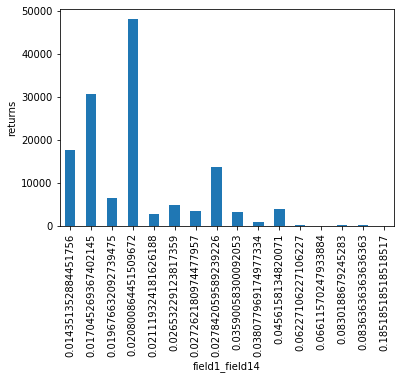

In [0]:
train_t.groupby('field1_field14')['field1_field14'].count().plot.bar()
plt.ylabel('returns')

In [0]:
df_copy['user_le'] = LabelEncoder().fit_transform(df_copy.userid)

In [0]:
gr_cols=['YEAR', 'MONTH_DEPART', 'DOW_DEPART', 'HOUR_DEPART']
df_grouped=df_copy.groupby(gr_cols).groups

In [0]:
list_ind = []
for _, v in df_grouped.items():
  list_ind.append(np.array(v, dtype='int32'))

len(list_ind)

3529

In [0]:
dict_depart = dict()
for label, depart in enumerate(list_ind):
  for user_index in depart:
      dict_depart[user_index] = label

df_copy['DEPART_INDEX'] = df_copy.index.to_series().map(dict_depart)

In [0]:
user3 = df_copy.query("USR_CNT==3")["user_le"].values
user4 = df_copy.query("USR_CNT==4")["user_le"].values


In [0]:
list_cnt = df_copy.query("USR_CNT>2")["USR_CNT"].unique()

In [0]:
from tqdm import tqdm_notebook

In [0]:
%%timeit

list_dicts = []
for cnt in tqdm_notebook(list_cnt):
  list_user_le = df_copy.query("USR_CNT == @cnt")['user_le'].values

  for i, user in tqdm_notebook(enumerate(list_user_le)):
    dep_ind = df_copy.DEPART_INDEX.where(df_copy.user_le == user).dropna().values.astype('int32')
    all_users = df_copy.user_le.where(df_copy.DEPART_INDEX.isin(dep_ind)).dropna().values.astype('int32')

    c = collections.Counter(all_users)
    d = dict()
    tmp = [k for k, _ in c.items() if c[k]==cnt]
    if len(tmp)>1:
      for value in tmp:
        d[value] = str(cnt) + '_' + str(i)

  if bool(d):
    list_dicts.append(d)

import json
colab_path = '/content/drive/My Drive/'
with open( os.path.join(colab_path,'list_dict.json'), 'w') as fp:
    json.dump(list_dicts, fp)


1 loop, best of 3: 9min 48s per loop


In [0]:
import collections

In [0]:
import json

colab_path = '/content/drive/My Drive/'
with open( os.path.join(colab_path,'list_dict2.json'), 'w') as fp:
    json.dump(list_dicts, fp)

In [0]:
all_users = df_copy.user_le.where(df_copy.DEPART_INDEX.isin(dep_ind)).dropna().values.astype('int32')

In [0]:
df_copy.query("user_le == 67401 & DEPART_INDEX==3277")

,orderid,userid,NDAYS_FROM_LAST,field1,MONTH_BUY,MONTH_DEPART,ORDER_OF_BUY,field5,field6,field7,field8,TICKET_CHILD_1Y,field10,HOUR_OF_BUY,field12,field13,field14,TOTAL_TICKETS,DAYS_BEFORE_DEPART,field17,DOW_BUY,field19,DOW_DEPART,YEAR,field22,HOUR_DEPART,TICKET_ADULT,field25,field26,field27,TICKET_CHILD_4Y,QUARTER,indicator_goal21,indicator_goal22,indicator_goal23,indicator_goal24,indicator_goal25,goal21,goal22,goal23,goal24,goal25,goal1,USR_CNT,INDICATOR_CNT,NDAYS_LAST_NEXT,TODAY,DIFF_HOUR_DEPART&HOUR_OF_BUY,DIFF_MONTH_DEPART&MONTH_OF_BUY,NUM_MONTH_BUY,NUM_MONTH_DEPART,DIFF_NUM_MONTH,DIFF_HOUR_DEPART&HOUR_OF_BUY_norm,CHILD,field1_field14,user_le,DEPART_INDEX
72219,72219,976fce59d2846df18470ebe89dacbe48fb8606f0c9c0e0...,2,0.381920,10,11,16,0,0,0,1,0,0,14,6,3,1.299621,1,3,1,1,1,4,1,6,12,1,4,3,1,0,4,1,1,0,1,1,0,0,0,0,0,0,110,0.799805,5,0,-2,1,10,11,1,-0.089051,0,226,67401,3277
78489,78489,976fce59d2846df18470ebe89dacbe48fb8606f0c9c0e0...,4,0.769776,11,11,30,0,0,0,1,0,0,17,6,3,1.859887,1,3,1,1,1,4,1,6,12,1,4,3,1,0,4,1,1,0,1,1,0,0,0,0,0,0,110,0.799805,7,0,-5,0,11,11,0,-0.222626,0,327,67401,3277
124724,124724,976fce59d2846df18470ebe89dacbe48fb8606f0c9c0e0...,0,0.071634,10,11,20,0,0,0,1,0,0,19,5,3,0.739355,1,2,1,2,1,4,1,99,12,1,22,1,1,0,4,1,1,0,0,1,0,0,0,0,0,0,110,0.600098,2,0,-7,1,10,11,1,-0.311677,0,155,67401,3277


In [0]:
c = collections.Counter(all_users)
d = collections.defaultdict(int)
for value in [k for k, _ in c.items() if c[k]==3 and k !=1583 ]:
  d[value] = 3

d

defaultdict(int, {17807: 3, 43407: 3, 67401: 3})

In [0]:
c = collections.Counter(all_users)
d = dict()
for value in [k for k, _ in c.items() if c[k]==3 and k !=1583 ]:
  d[value] = 3

d

{17807: 3, 43407: 3, 67401: 3}

In [0]:
len([k for k, _ in c.items() if c[k]==3 and k !=1583 ]

3

In [0]:
df_copy.loc[df_copy.field1_field14.isin(largest_users100), :]

,orderid,userid,NDAYS_FROM_LAST,field1,MONTH_BUY,MONTH_DEPART,ORDER_OF_BUY,field5,field6,field7,field8,TICKET_CHILD_1Y,field10,HOUR_OF_BUY,field12,field13,field14,TOTAL_TICKETS,DAYS_BEFORE_DEPART,field17,DOW_BUY,field19,DOW_DEPART,YEAR,field22,HOUR_DEPART,TICKET_ADULT,field25,field26,field27,TICKET_CHILD_4Y,QUARTER,indicator_goal21,indicator_goal22,indicator_goal23,indicator_goal24,indicator_goal25,goal21,goal22,goal23,goal24,goal25,goal1,USR_CNT,INDICATOR_CNT,NDAYS_LAST_NEXT,TODAY,DIFF_HOUR_DEPART&HOUR_OF_BUY,DIFF_MONTH_DEPART&MONTH_OF_BUY,NUM_MONTH_BUY,NUM_MONTH_DEPART,DIFF_NUM_MONTH,field1_field14,DIFF_HOUR_DEPART&HOUR_OF_BUY_norm
0,0,10d654494cbe97bbb25d51ead2600679aff9e097924add...,0,-0.626508,11,12,1,1,0,1,1,0,0,9,5,20,-0.661308,1,4,1,4,1,1,1,1,15,1,1,2,1,0,4,1,1,0,1,1,0,1,0,0,0,0,1,0.799805,4,0,6,1,11,12,1,106,0.267152
1,1,4aafc0391f72bbcf60537aece62923baf9ce644b64ac36...,144,-0.393794,5,7,2,0,0,0,1,0,0,21,125,3,-0.101043,1,57,1,5,1,6,0,121,15,1,41,3,1,0,2,1,1,0,1,0,0,0,0,0,0,0,2,0.600098,201,0,-6,2,-7,-5,2,69,-0.267152
2,2,bac8ffef46348f587c8d17137ab01fb24aef21547c647d...,134,-0.548937,2,3,2,0,0,1,1,0,1,7,4,3,-0.661308,1,4,1,2,3,6,0,17,14,1,1,11,7,0,1,1,1,0,1,1,0,0,0,0,0,0,2,0.799805,138,0,7,1,-10,-9,1,95,0.311677
3,3,0392247b4b87674aba2c32bf2292b105771a6a376871be...,0,-0.238651,10,11,1,1,3,0,1,0,0,19,12,3,-0.521242,2,22,1,3,3,4,1,46,12,2,18,1,1,0,4,1,1,0,1,1,0,0,0,0,0,0,3,0.799805,22,0,-7,1,10,11,1,44,-0.311677
4,4,d1aeefef311bbeb4bd84876c8d49421f276674527d5578...,0,-0.704079,8,11,1,1,0,1,1,0,1,16,4,3,-0.801375,1,100,1,6,1,1,1,17,22,1,1,1,1,0,3,1,1,0,0,1,0,0,0,0,0,0,1,0.600098,100,0,6,3,8,11,3,118,0.267152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196050,196050,1516f11203426985c1a03f3c98569c31340f020b945e85...,0,-0.083509,6,6,1,1,0,1,1,0,0,19,18,3,0.459223,1,10,1,1,2,4,1,48,20,1,1,3,1,0,2,1,1,0,1,1,0,0,0,0,0,0,1,0.799805,10,0,1,0,6,6,0,24,0.044525
196051,196051,e33b0b1abb0038261ea9fb5213b9aad000a7686edab9e4...,30,-0.083509,7,7,2,0,0,0,1,0,1,0,91,511,0.459223,1,4,33,7,2,3,1,1,17,1,1,3,1,0,3,1,1,0,1,0,0,0,0,0,0,0,4,0.600098,34,0,17,0,7,7,0,24,0.756930
196052,196052,ed64c2d35a57e9e8e8e5bc84f3addf5552e1691a52a75d...,104,-0.548937,11,11,2,0,0,1,1,0,0,8,5,16,-0.521242,1,0,1,5,2,5,1,1,23,1,1,12,3,0,4,1,1,0,0,0,0,0,0,0,0,0,2,0.399902,104,1,15,0,11,11,0,94,0.667879
196054,196054,ddd567f873d77e2118458a4d4bf51643c95df4bbad7dba...,0,-0.704079,11,1,1,1,0,1,1,0,0,23,12,3,-0.801375,2,53,1,6,2,3,1,51,23,2,1,1,1,0,4,1,1,0,1,1,0,0,0,0,0,0,3,0.799805,53,0,0,-10,11,1,-10,118,0.000000
